# Videogames sales prediction
By
Aidar Ospankulov,
Olzhas Assetuly,
Timur Seitov,
Eldar Batkenov


# Introduction

  The objective of our project is the development and evaluation of three time series forecasting models designed to predict video game sales across various genres. Accurate sales forecasting is crucial for the video game industry, informing decisions related to production, marketing, and distribution. This project addresses this need by implementing and comparing three distinct time series models: SARIMA, LSTM, and Prophet

# Report Structure


1. Dataset Description
2. Data visualization
3. **SARIMA** prediction model
4. **LSTM** prediction model
5. **Prophet** prediction model
6. Comparison
7. Conclusion



# Dataset Description


The dataset's name is **vgchartz-2024**. It has more than 64000 of entries.

Fields include



*   ***img (Image)***: Link or path to the game's cover image or screenshot

*   ***title (Title)***: The full title of the video game

*   ***console (Console)***: The platform the game was released on
*   ***genre (Genre)*** : The genre of the video game


*   **publisher (Publisher *Курсив*)**: The company that published the game


*  ***developer (Developer)***: The company that developed the game


*   ***total_sales (Total Sales)***: The total number of copies of the game sold worldwide
*   ***na_sales (North American Sales)***: The number of copies of the game sold in North America (USA, Canada, Mexico)


*   ***jp_sales (Japanese Sales)***: The number of copies of the game sold in Japan.

*   ***pal_sales (European Sales)***: The number of copies of the game sold in PAL regions (Europe, Australia, and other countries)
*   ***other_sales (Other Region Sales)***: The number of copies of the game sold in other regions of the world not included in NA, JP, and PAL


*   ***release_date (Release Date)***: The date the game was released

*   ***last_update***: The date when the game information in the dataset was last updated












In [70]:
df.head(10)

img  \
0      /games/boxart/full_6510540AmericaFrontccc.jpg   
1      /games/boxart/full_5563178AmericaFrontccc.jpg   
2                        /games/boxart/827563ccc.jpg   
3      /games/boxart/full_9218923AmericaFrontccc.jpg   
4      /games/boxart/full_4990510AmericaFrontccc.jpg   
5  /games/boxart/full_call-of-duty-modern-warfare...   
6  /games/boxart/full_call-of-duty-black-ops_5Ame...   
7      /games/boxart/full_4653215AmericaFrontccc.jpg   
8      /games/boxart/full_1977964AmericaFrontccc.jpg   
9      /games/boxart/full_4649679AmericaFrontccc.png   

                            title console             genre       publisher  \
0              Grand Theft Auto V     PS3            Action  Rockstar Games   
1              Grand Theft Auto V     PS4            Action  Rockstar Games   
2     Grand Theft Auto: Vice City     PS2            Action  Rockstar Games   
3              Grand Theft Auto V    X360            Action  Rockstar Games   
4       Call of Duty: Black Ops 3     PS4           Shooter      Activision   
5  Call of Duty: Modern Warfare 3    X360           Shooter      Activision   
6         Call of Duty: Black Ops    X360           Shooter      Activision   
7           Red Dead Redemption 2     PS4  Action-Adventure  Rockstar Games   
8      Call of Duty: Black Ops II    X360           Shooter      Activision   
9      Call of Duty: Black Ops II     PS3           Shooter      Activision   

        developer  critic_score  total_sales  na_sales  jp_sales  pal_sales  \
0  Rockstar North           9.4        20.32      6.37      0.99       9.85   
1  Rockstar North           9.7        19.39      6.06      0.60       9.71   
2  Rockstar North           9.6        16.15      8.41      0.47       5.49   
3  Rockstar North           NaN        15.86      9.06      0.06       5.33   
4        Treyarch           8.1        15.09      6.18      0.41       6.05   
5   Infinity Ward           8.7        14.82      9.07      0.13       4.29   
6        Treyarch           8.8        14.74      9.76      0.11       3.73   
7  Rockstar Games           9.8        13.94      5.26      0.21       6.21   
8        Treyarch           8.4        13.86      8.27      0.07       4.32   
9        Treyarch           8.0        13.80      4.99      0.65       5.88   

   other_sales release_date last_update;;  year  
0         3.12   2013-09-17            ;;  2013  
1         3.02   2014-11-18  2018-01-03;;  2014  
2         1.78   2002-10-28            ;;  2002  
3         1.42   2013-09-17            ;;  2013  
4         2.44   2015-11-06  2018-01-14;;  2015  
5         1.33   2011-11-08            ;;  2011  
6         1.14   2010-11-09            ;;  2010  
7         2.26   2018-10-26  2018-11-02;;  2018  
8         1.20   2012-11-13  2018-04-07;;  2012  
9         2.28   2012-11-13  2018-04-07;;  2012

# Data preparation


Prophet installation


In [3]:
!pip install prophet

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from prophet import Prophet


# Data loading
df = pd.read_csv("vgchartz-2024.csv", encoding='latin1')

df = df.dropna(subset=['release_date', 'total_sales']).copy()
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

df['year'] = df['release_date'].dt.year
sales_by_year = df.groupby('year')['total_sales'].sum().reset_index()

Dataset' columns

In [63]:
print(df.columns)


Index(['img', 'title', 'console', 'genre', 'publisher', 'developer',
       'critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales',
       'other_sales', 'release_date', 'last_update;;', 'year'],
      dtype='object')


Let's see dataset's videogame genres

In [64]:
print(df['genre'].unique())

['Action' 'Shooter' 'Action-Adventure' 'Sports' 'Role-Playing'
 'Simulation' 'Racing' 'Music' 'Misc' 'Fighting' 'Platform' 'Adventure'
 'Strategy' 'Puzzle' 'MMO' 'Sandbox' 'Party' 'Education' 'Board Game'
 'Visual Novel']


All videogame sales all time

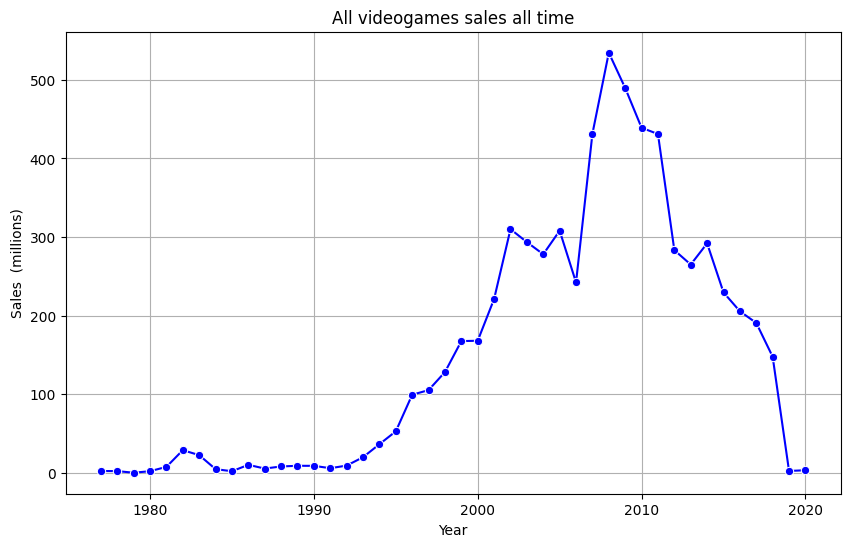

In [65]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=sales_by_year, x='year', y='total_sales', marker='o', color='b')
plt.title('All videogames sales all time')
plt.xlabel('Year')
plt.ylabel('Sales  (millions)')
plt.grid(True)
plt.show()

# GENRES SALES ALL TIME

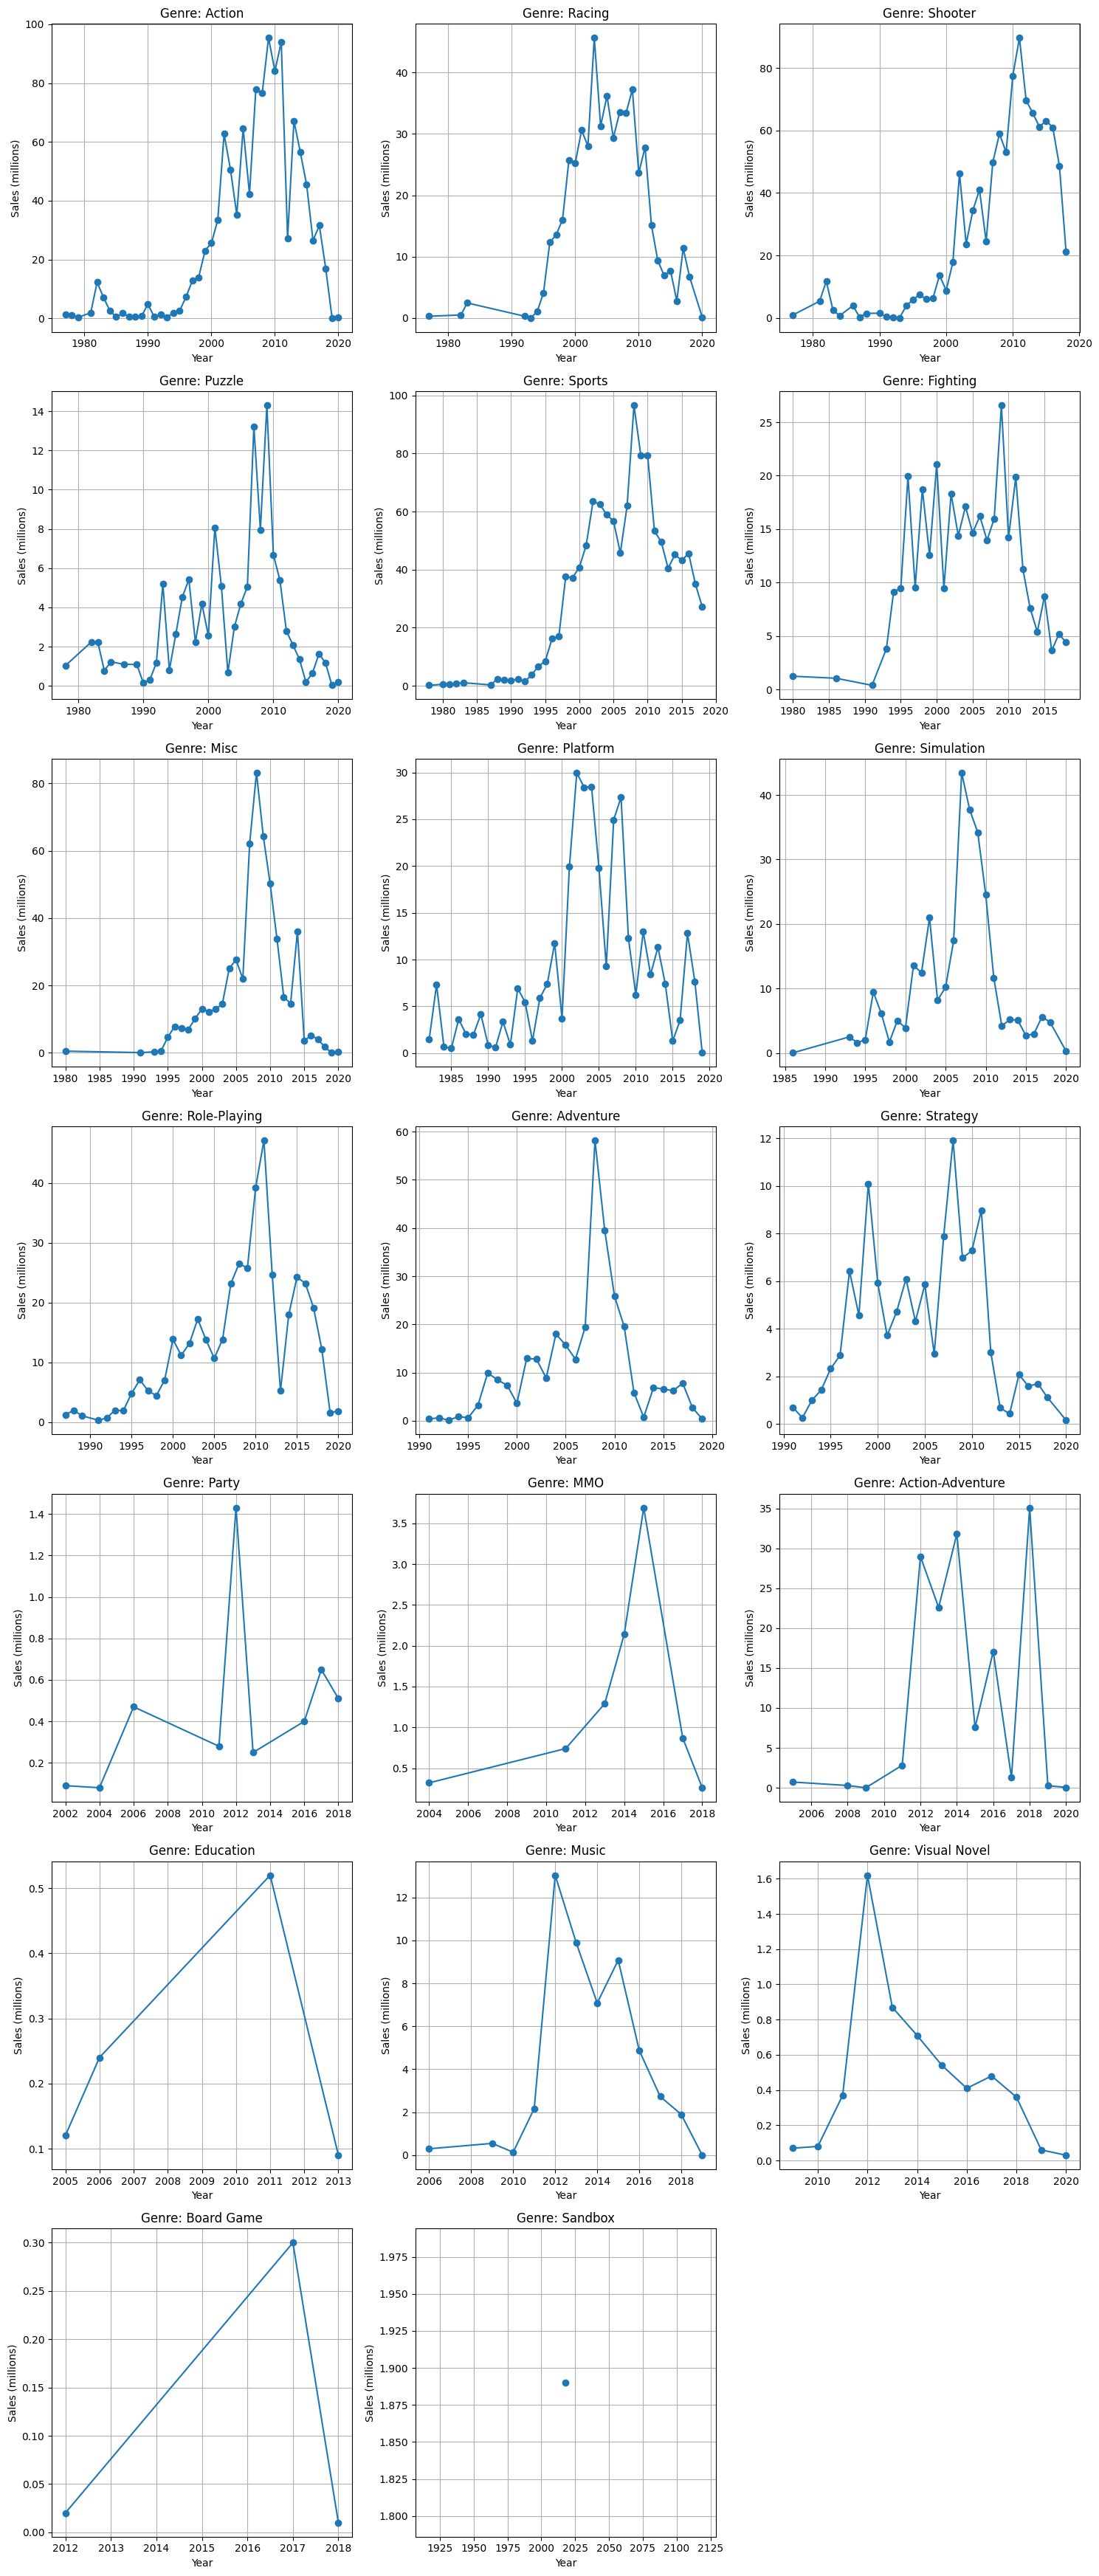

In [66]:

df = df.dropna(subset=['release_date', 'total_sales', 'genre']).copy()
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year

# data grouping
sales_by_genre_year = df.groupby(['year', 'genre'])['total_sales'].sum().reset_index()

genres = sales_by_genre_year['genre'].unique()

num_genres = len(genres)
fig, axes = plt.subplots(nrows=(num_genres // 3) + 1, ncols=3, figsize=(15, 5 * ((num_genres // 3) + 1)))
axes = axes.flatten()

# graphics for each genre
for i, genre in enumerate(genres):
    genre_data = sales_by_genre_year[sales_by_genre_year['genre'] == genre]
    axes[i].plot(genre_data['year'], genre_data['total_sales'], marker='o', color='tab:blue', linestyle='-')
    axes[i].set_title(f"Genre: {genre}")
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Sales (millions)')
    axes[i].grid(True)

for i in range(len(genres), len(axes)):
    fig.delaxes(axes[i])

# Common graphic
plt.tight_layout()
plt.show()


# SARIMA prediction model


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<

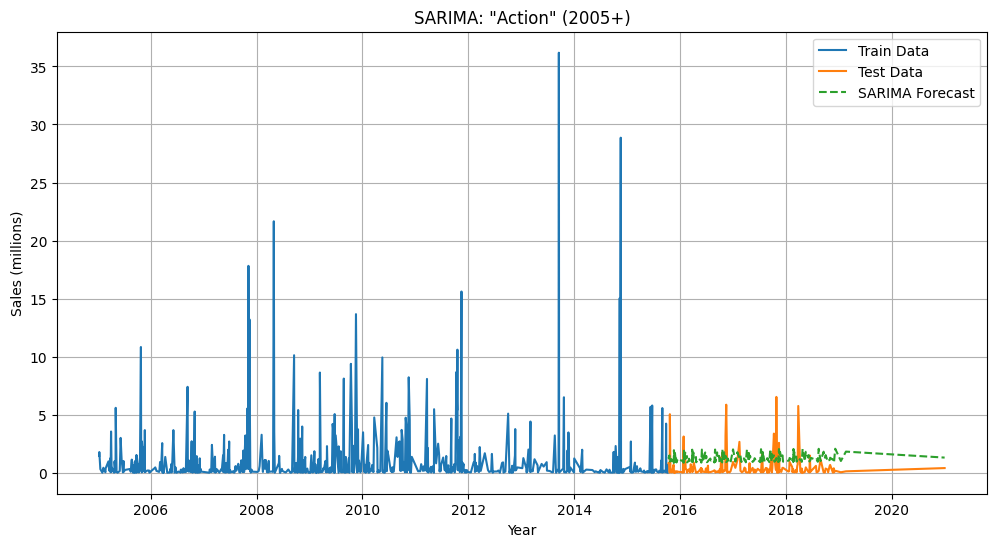

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<

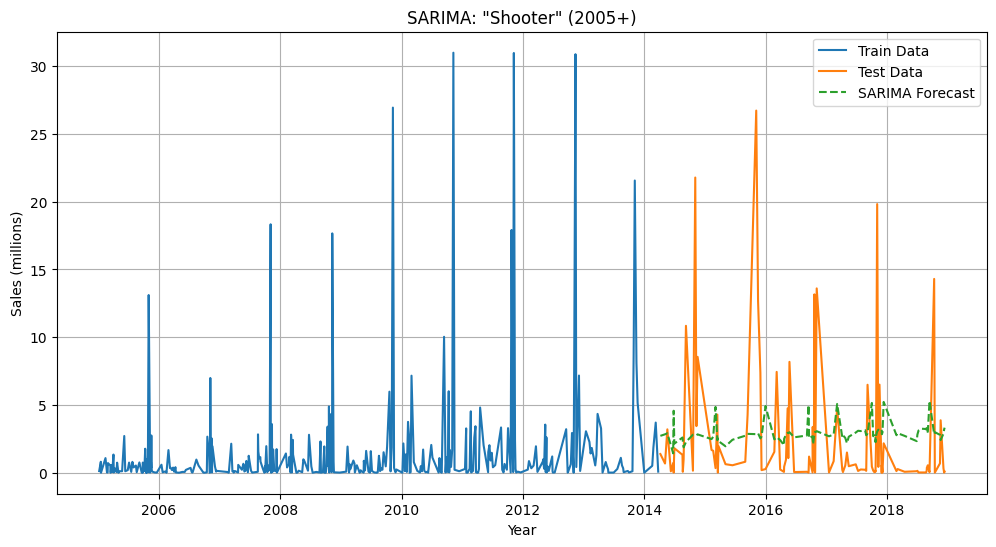

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<

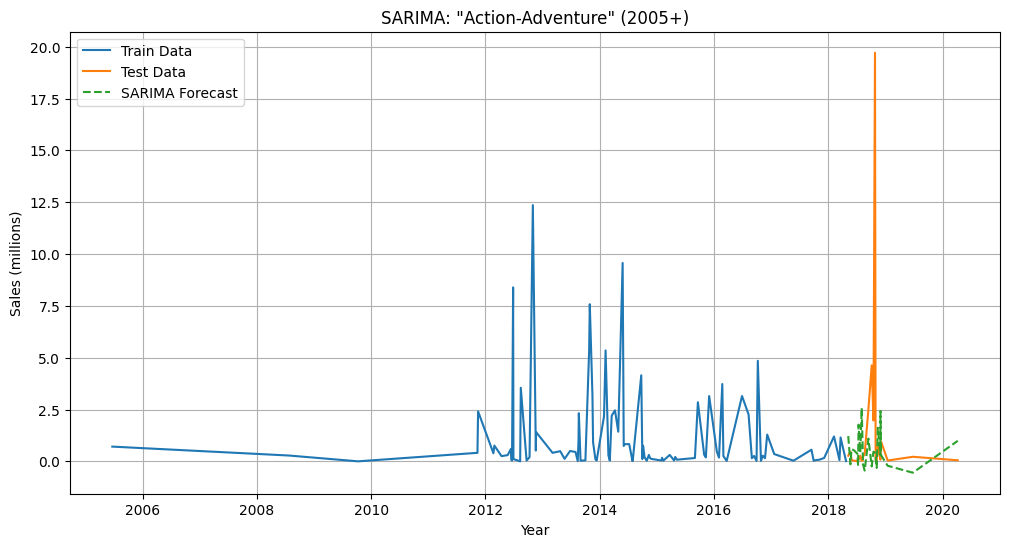

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<

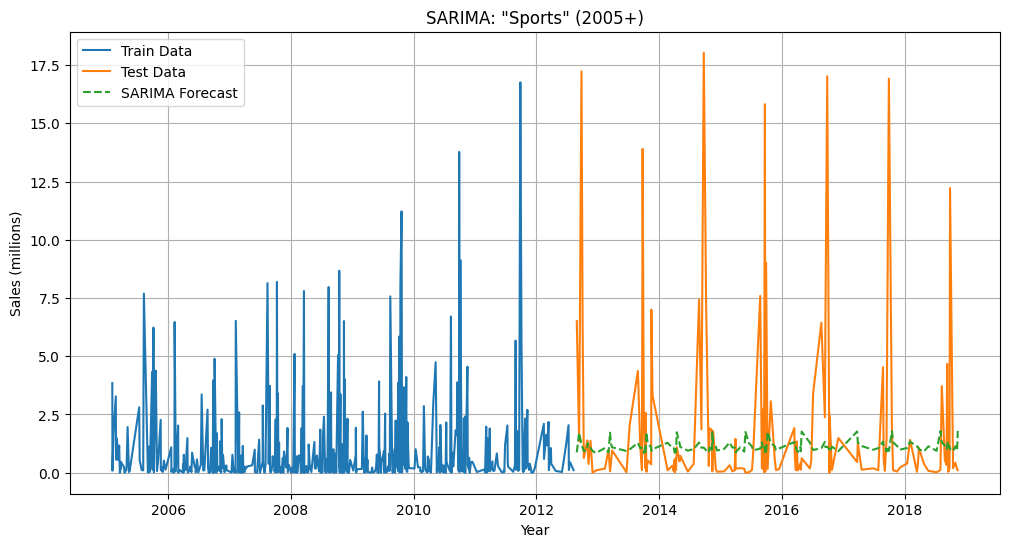

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<

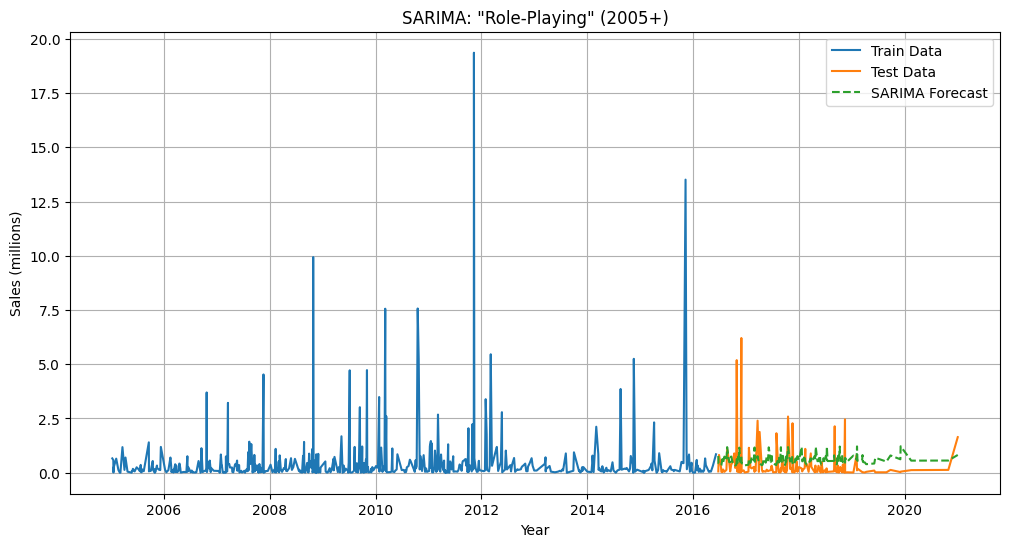

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<

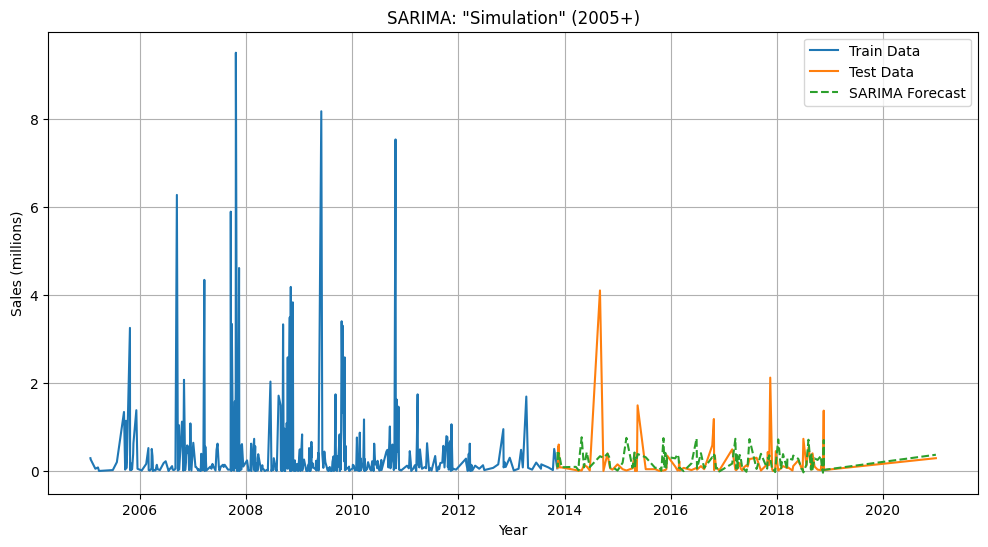

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<

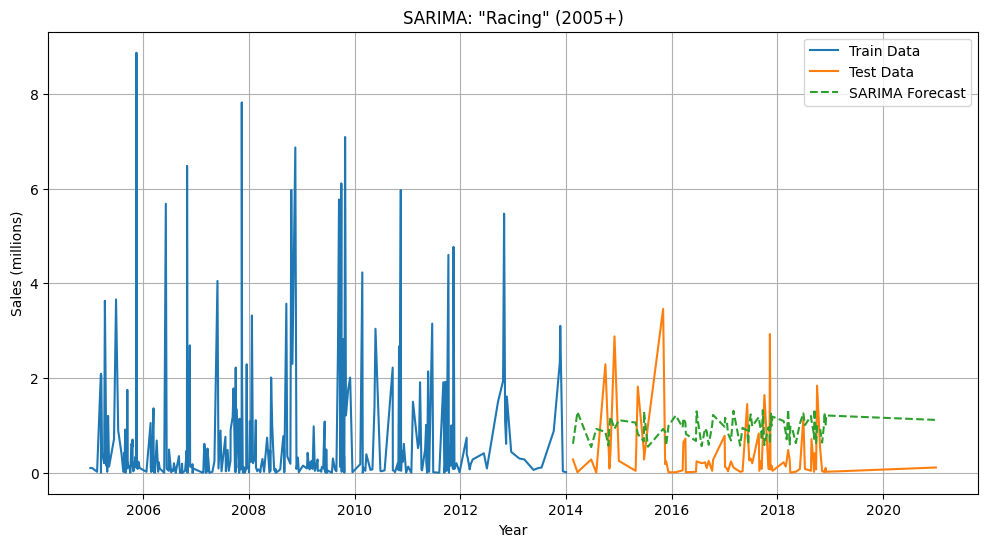

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-pack

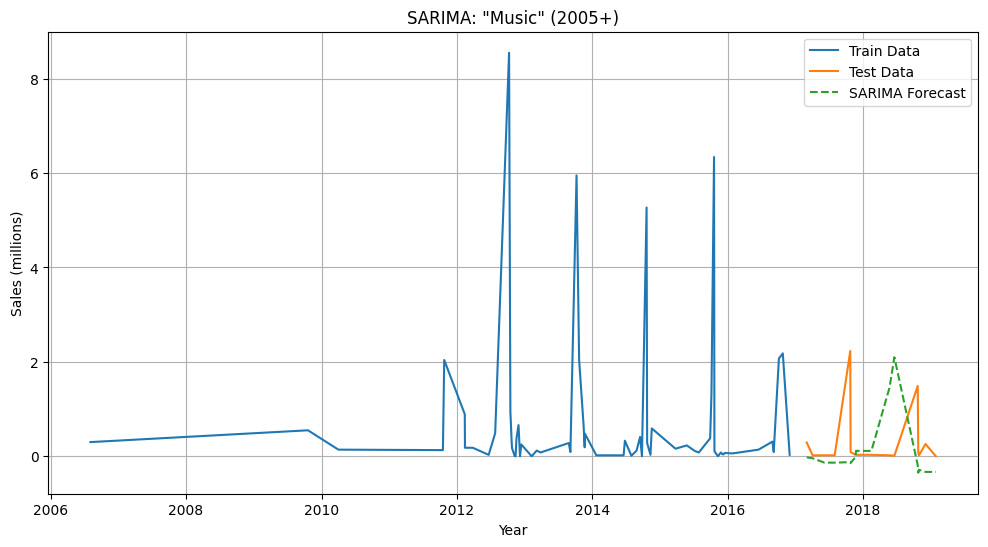

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<

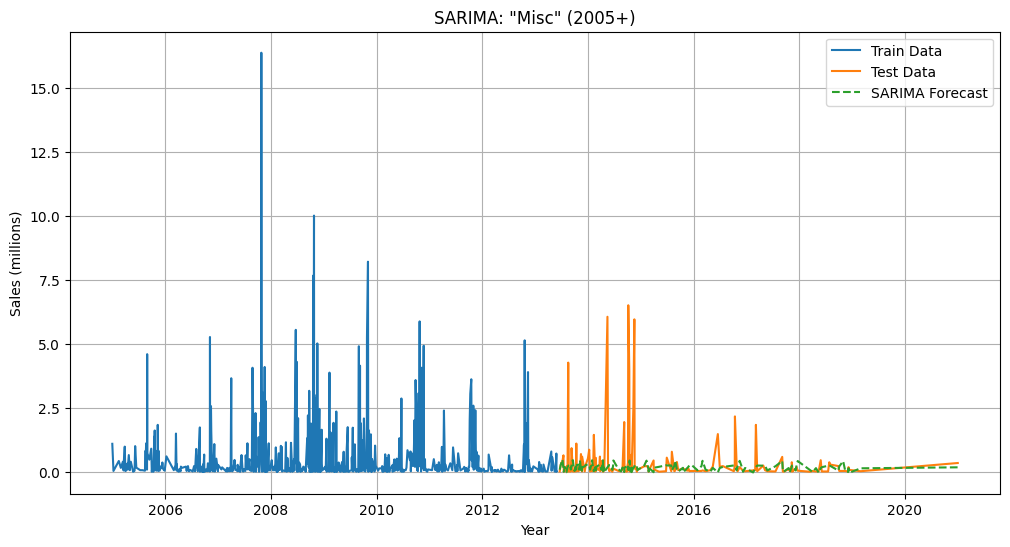

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<

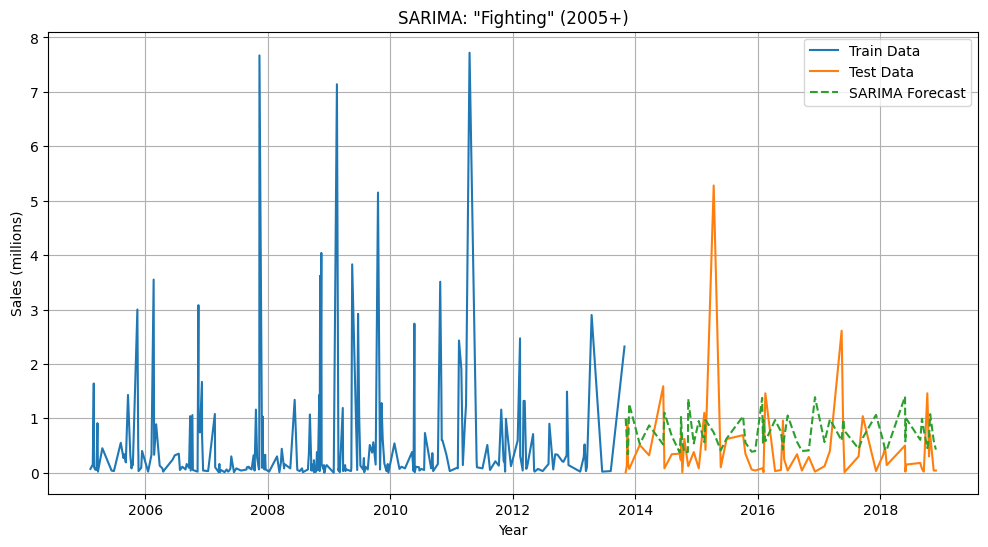

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<

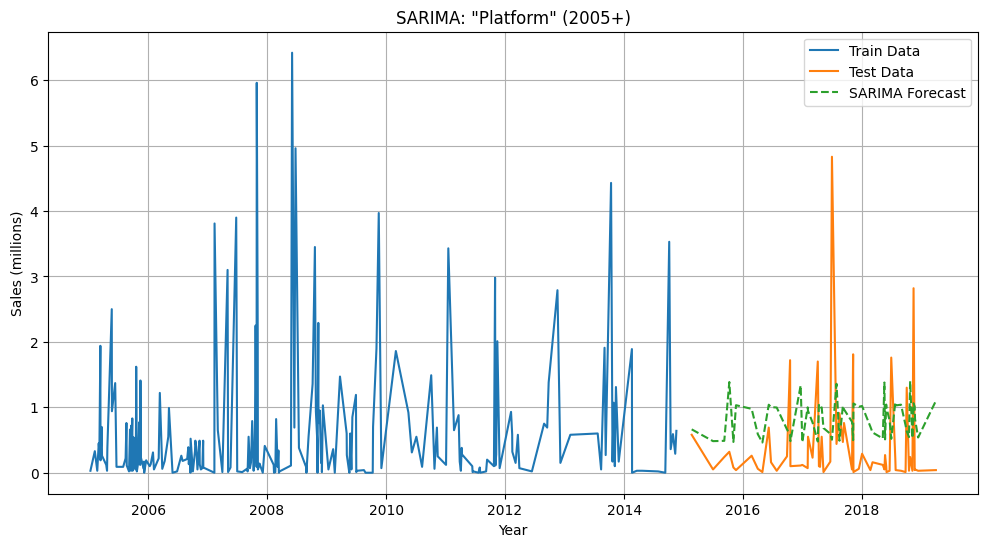

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<

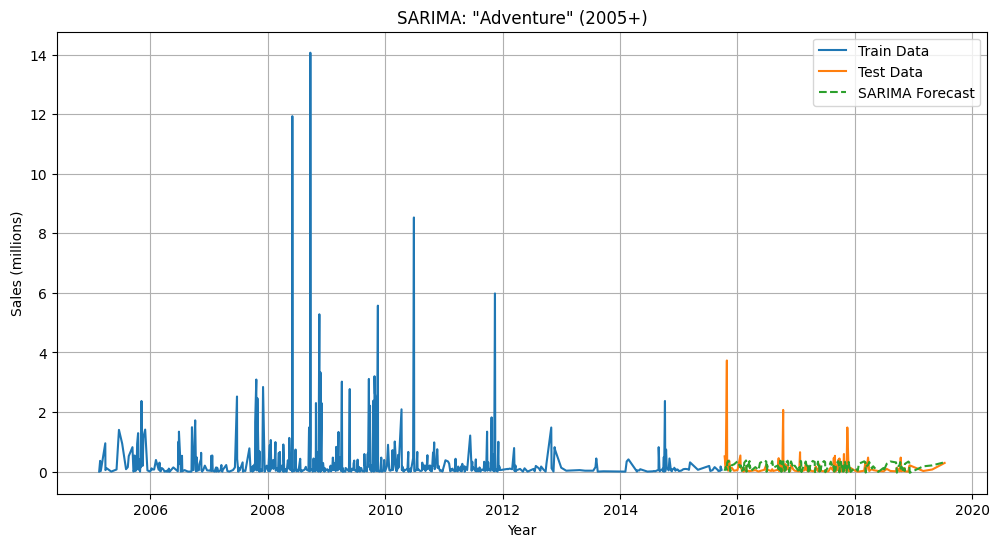

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/stat

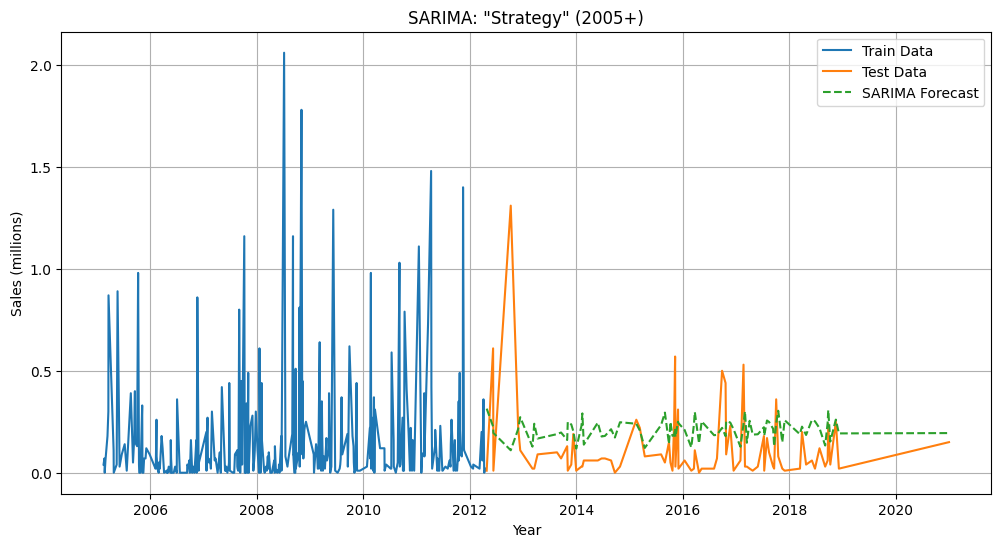

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<

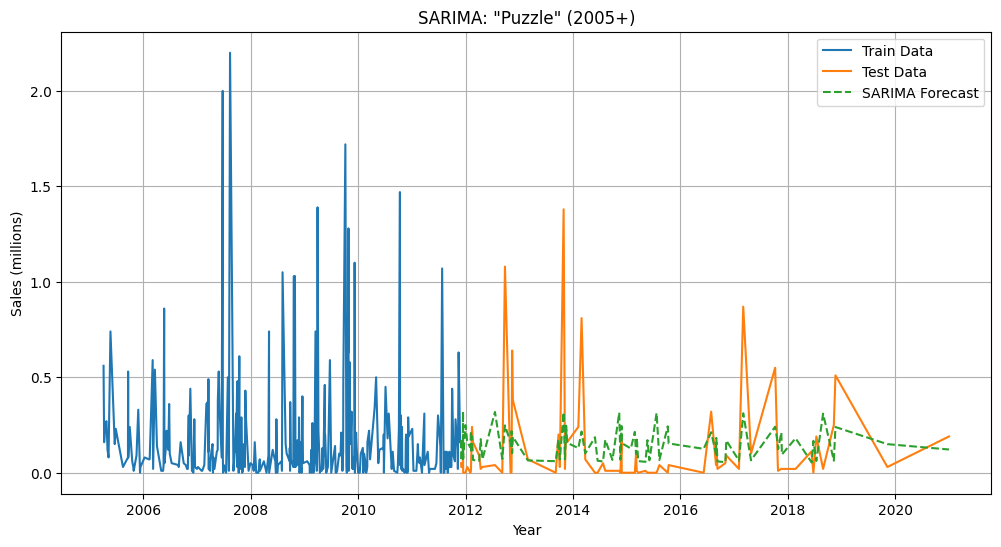

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<

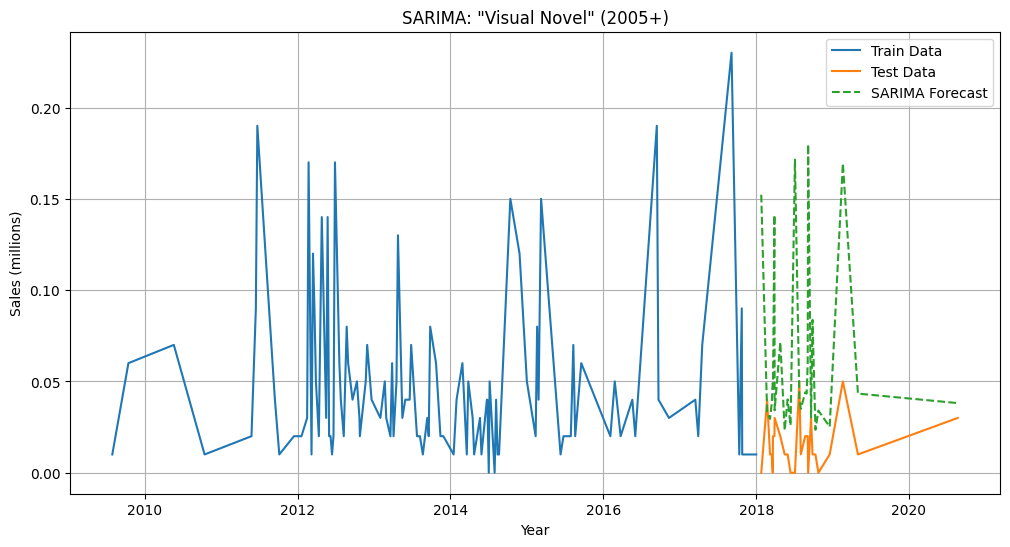

In [67]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


genres = ['Action', 'Shooter', 'Action-Adventure', 'Sports', 'Role-Playing',
          'Simulation', 'Racing', 'Music', 'Misc', 'Fighting', 'Platform',
          'Adventure', 'Strategy', 'Puzzle', 'MMO', 'Sandbox', 'Party',
          'Education', 'Board Game', 'Visual Novel']


metrics = {}


df['release_date'] = pd.to_datetime(df['release_date'])

# model builing
for genre in genres:
    genre_data = df[df['genre'] == genre].groupby('release_date')['total_sales'].sum().reset_index()
    genre_data.set_index('release_date', inplace=True)
    genre_data = genre_data.loc[genre_data.index >= '2005-01-01']

    # Если данных недостаточно, пропускаем жанр
    if len(genre_data) < 24:  # Минимум 2 года данных для SARIMA
        continue

    #train and test
    train_size = int(len(genre_data) * 0.8)
    train = genre_data.iloc[:train_size]
    test = genre_data.iloc[train_size:]

    # SARIMA
    try:
        sarima_model = SARIMAX(train['total_sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_results = sarima_model.fit(disp=False)

        # forecast
        sarima_forecast = sarima_results.forecast(steps=len(test))

        # metrics
        mse = mean_squared_error(test['total_sales'], sarima_forecast)
        mae = mean_absolute_error(test['total_sales'], sarima_forecast)
        mape = np.mean(np.abs((test['total_sales'] - sarima_forecast) / test['total_sales'])) * 100

        # Сохранение метрик

        metrics[genre] = {'MSE': mse, 'MAE': mae}

        # visualization
        plt.figure(figsize=(12, 6))
        plt.plot(train.index, train['total_sales'], label='Train Data')
        plt.plot(test.index, test['total_sales'], label='Test Data')
        plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', linestyle='--')
        plt.title(f'SARIMA: "{genre}" (2005+)')
        plt.xlabel('Year')
        plt.ylabel('Sales (millions)')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f'Error for genre {genre}: {e}')


# metrics_df = pd.DataFrame(metrics).T
# print(metrics_df)


SARIMA's metrics

In [68]:
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

                        MSE       MAE
Action             1.694458  1.106854
Shooter           24.546522  3.358277
Action-Adventure  16.835404  1.714458
Sports            15.478426  2.036738
Role-Playing       0.741123  0.581965
Simulation         0.248868  0.251096
Racing             0.833285  0.812693
Music              0.983285  0.646195
Misc               1.017680  0.385102
Fighting           0.806810  0.641629
Platform           0.980857  0.805820
Adventure          0.160339  0.208173
Strategy           0.046680  0.163134
Puzzle             0.052952  0.150419
Visual Novel       0.004969  0.048065


# LSTM prediction model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


<ipython-input-69-56ecbd4689b7>:66: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - lstm_forecast) / y_test)) * 100


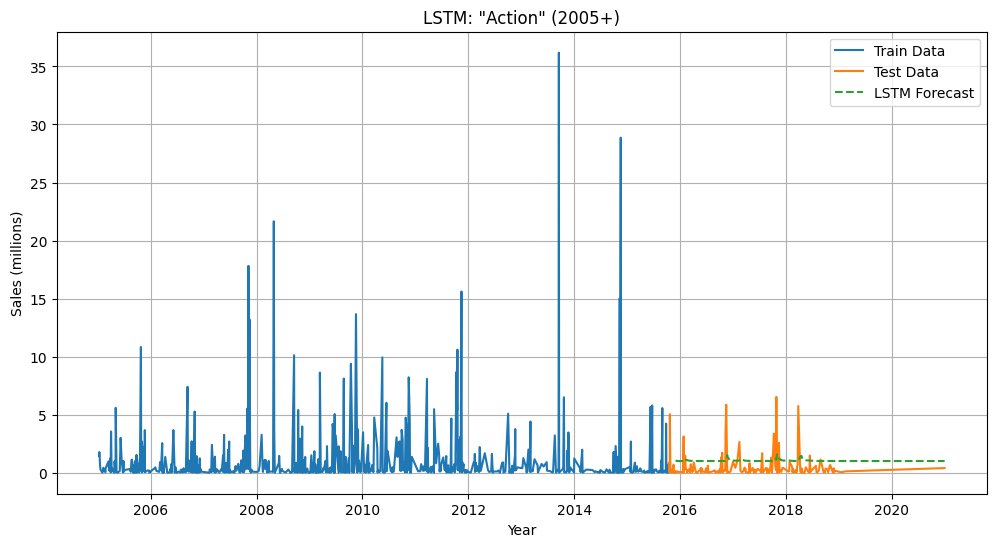

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step


<ipython-input-69-56ecbd4689b7>:66: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - lstm_forecast) / y_test)) * 100


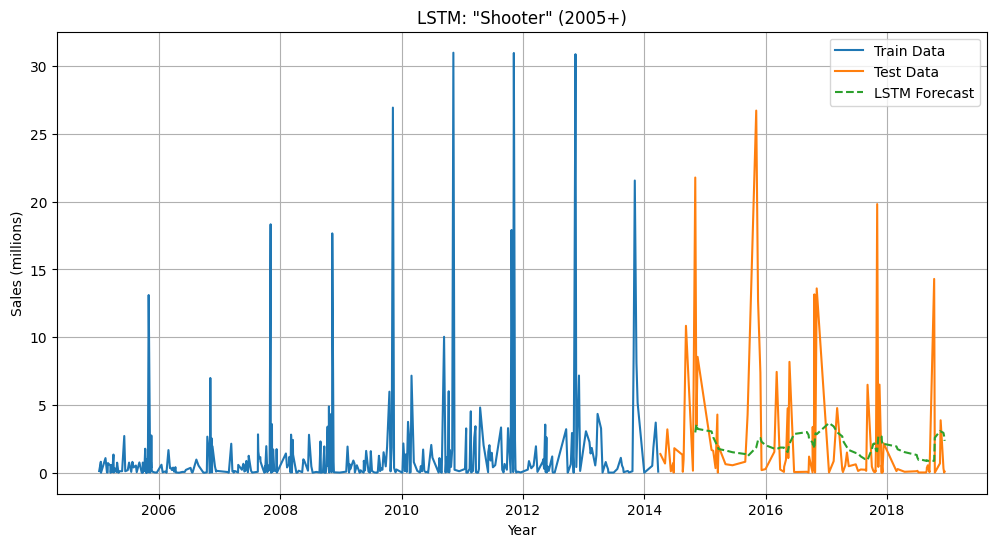

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


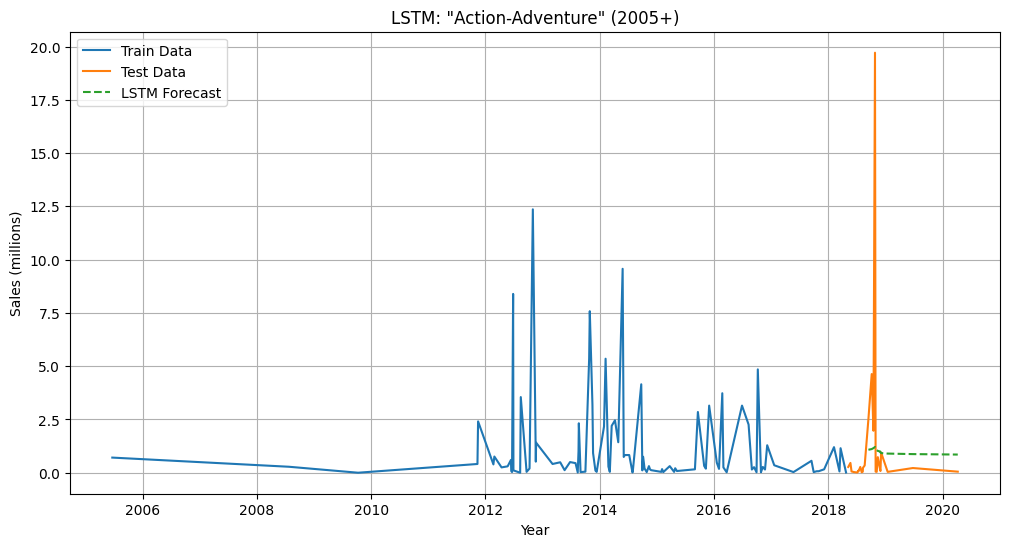

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


<ipython-input-69-56ecbd4689b7>:66: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - lstm_forecast) / y_test)) * 100


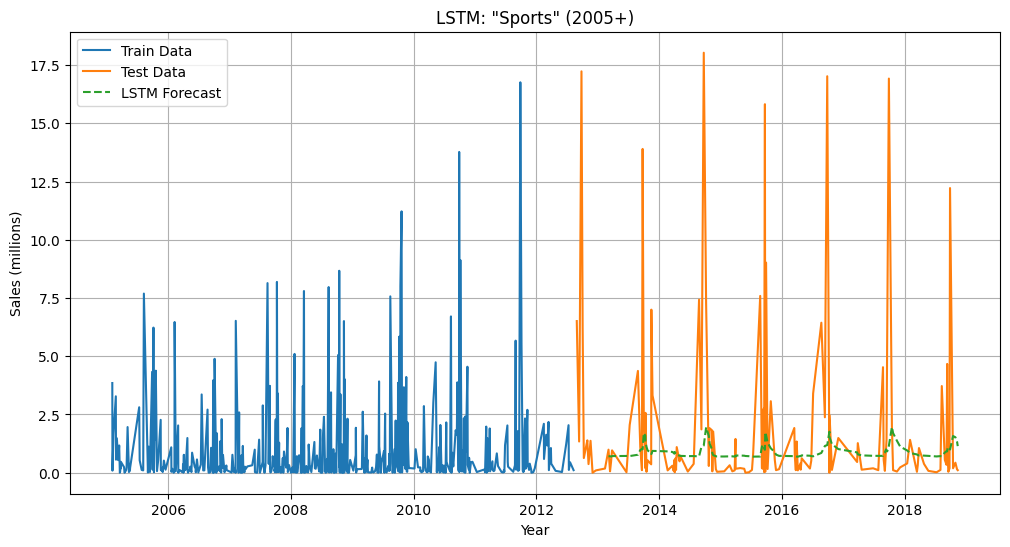

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


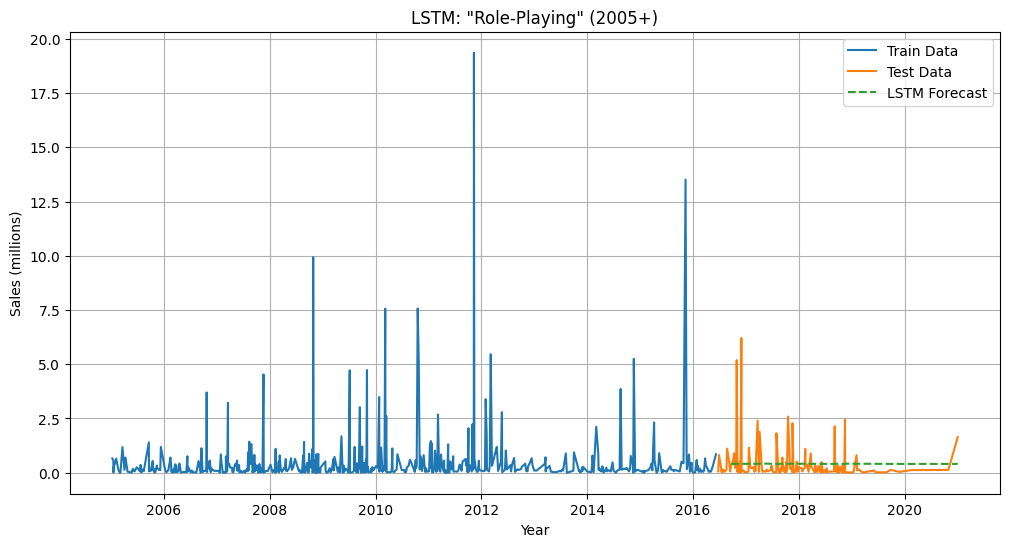

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


<ipython-input-69-56ecbd4689b7>:66: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - lstm_forecast) / y_test)) * 100


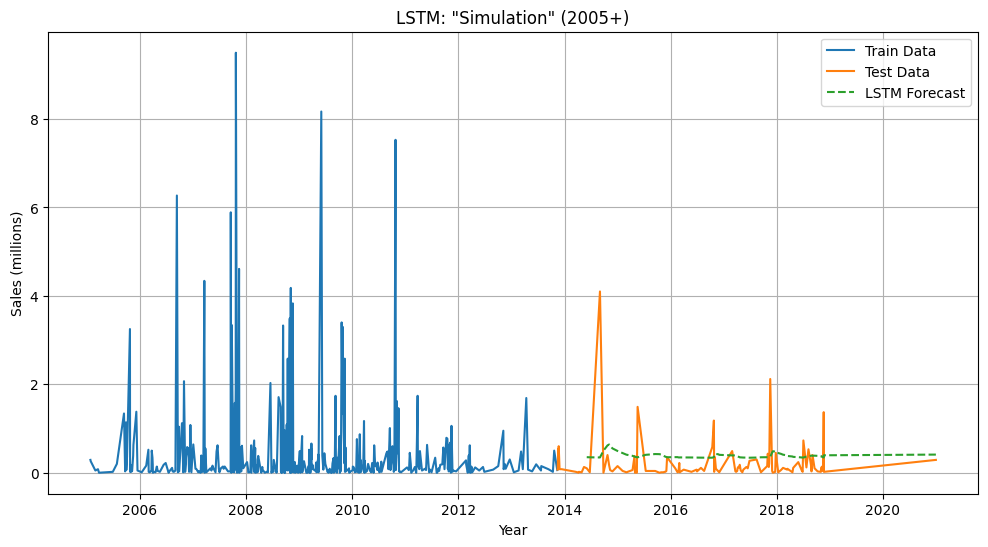

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


<ipython-input-69-56ecbd4689b7>:66: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - lstm_forecast) / y_test)) * 100


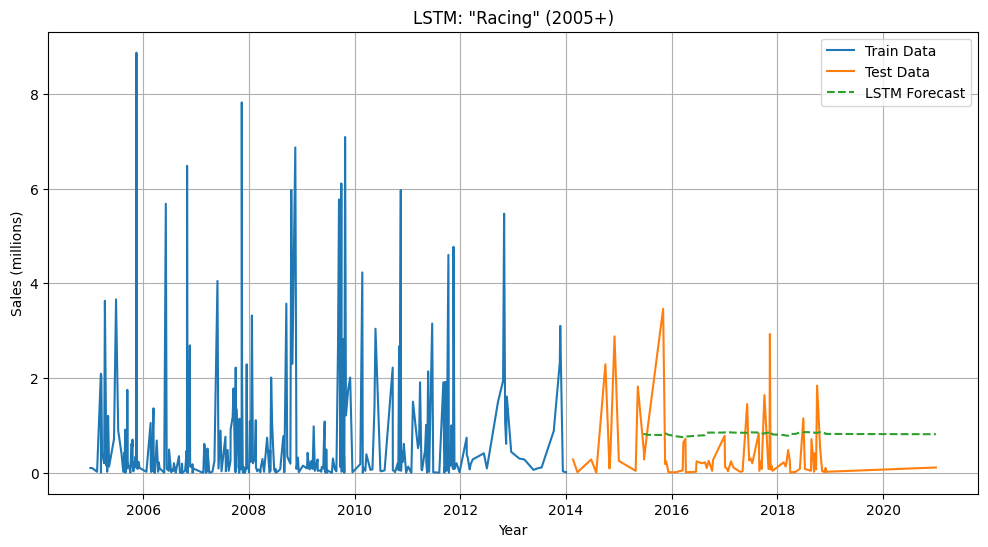

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


<ipython-input-69-56ecbd4689b7>:66: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - lstm_forecast) / y_test)) * 100


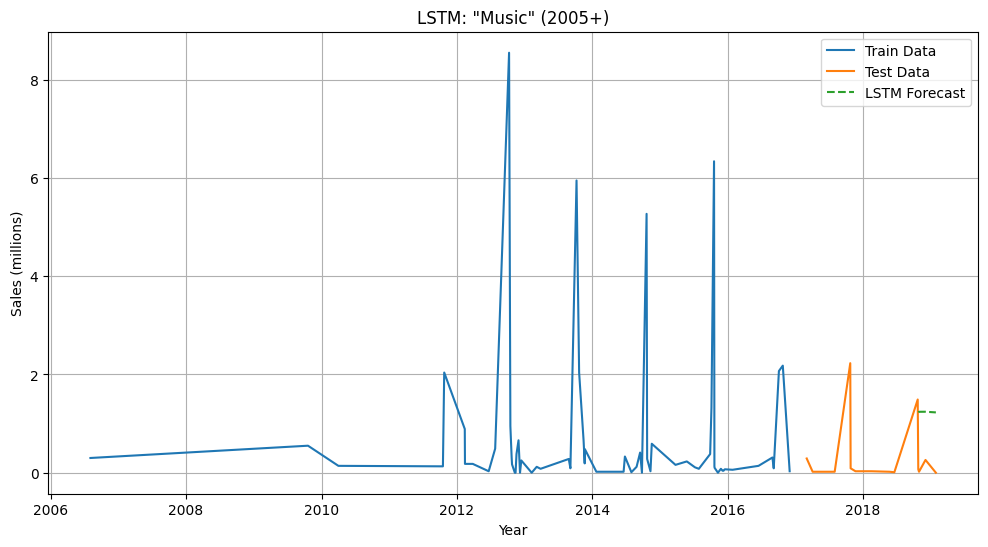

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


<ipython-input-69-56ecbd4689b7>:66: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - lstm_forecast) / y_test)) * 100


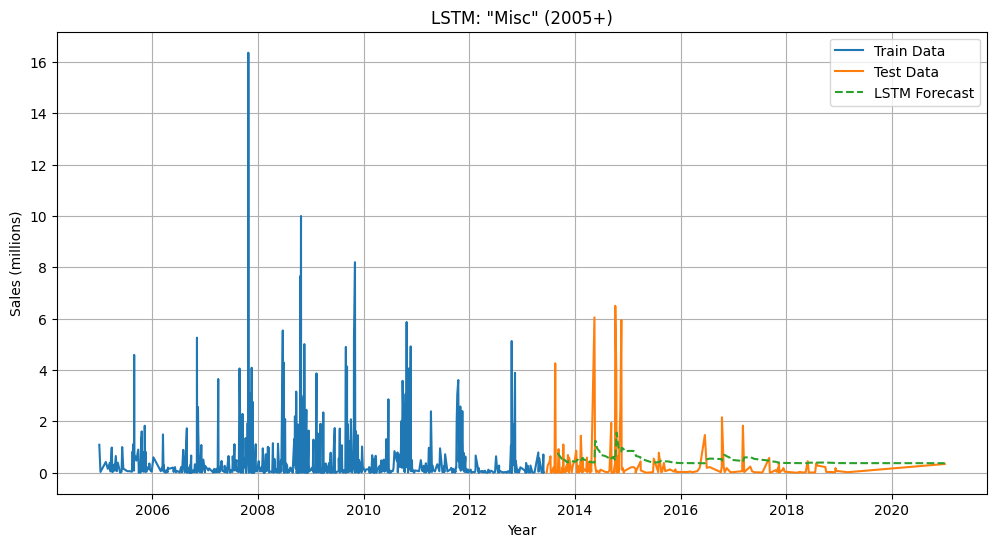

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step


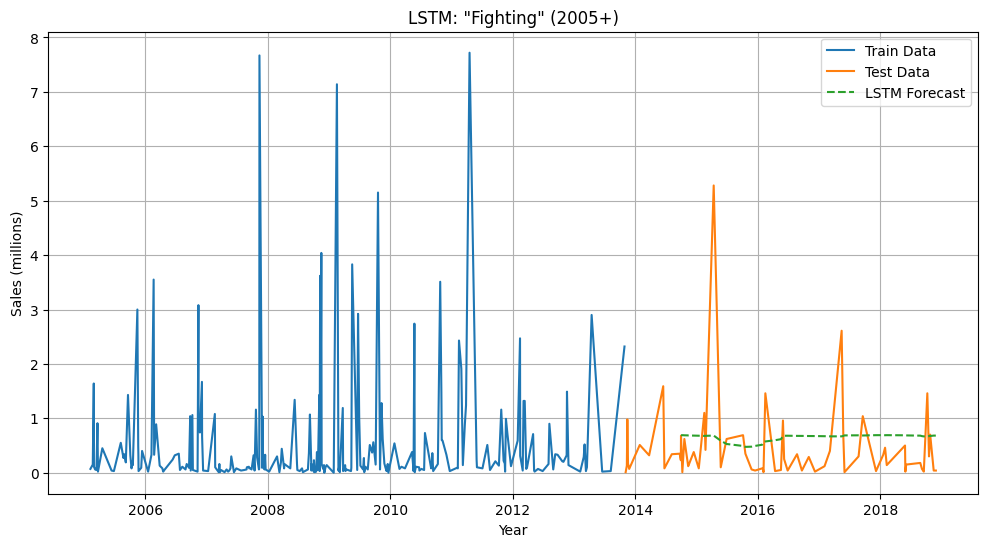

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step


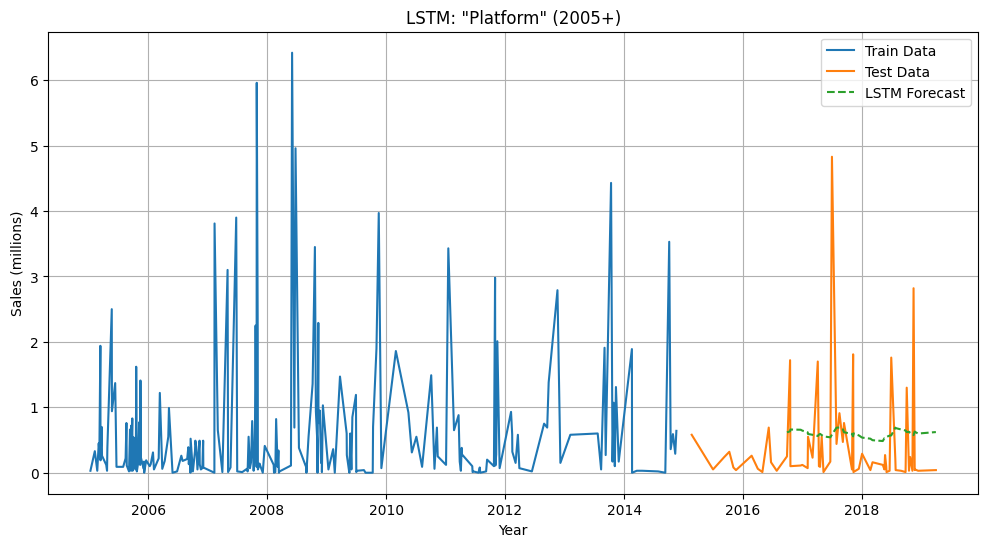

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


<ipython-input-69-56ecbd4689b7>:66: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - lstm_forecast) / y_test)) * 100


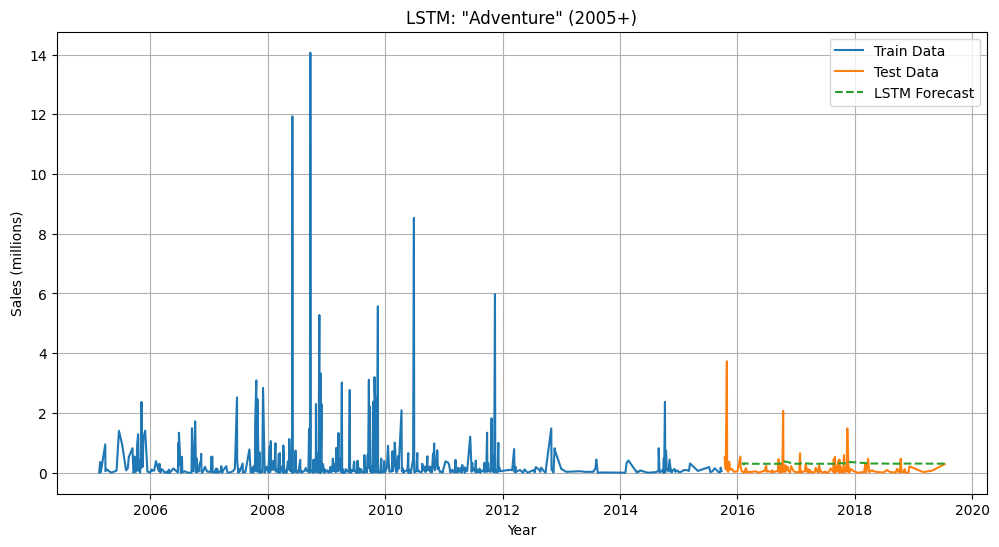

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


<ipython-input-69-56ecbd4689b7>:66: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - lstm_forecast) / y_test)) * 100


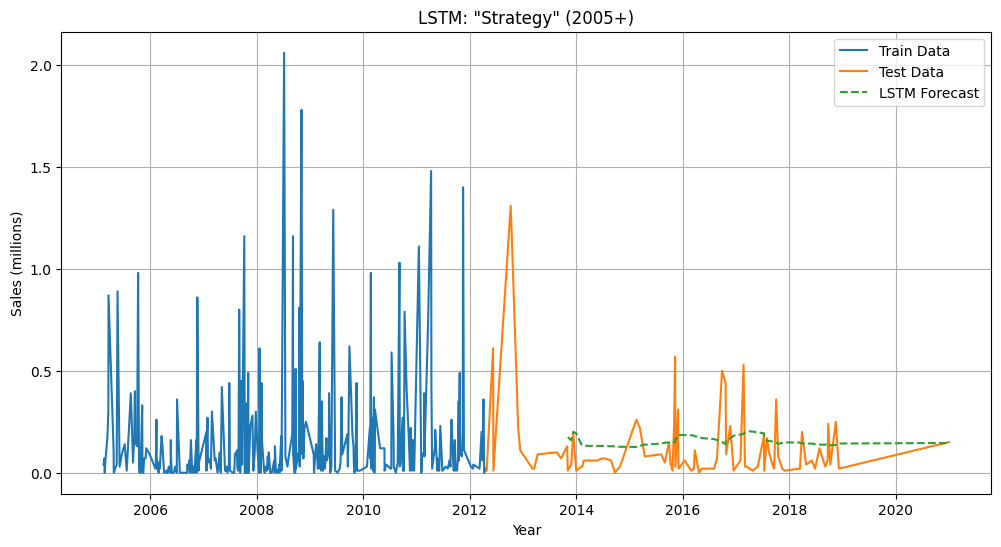

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step


<ipython-input-69-56ecbd4689b7>:66: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - lstm_forecast) / y_test)) * 100


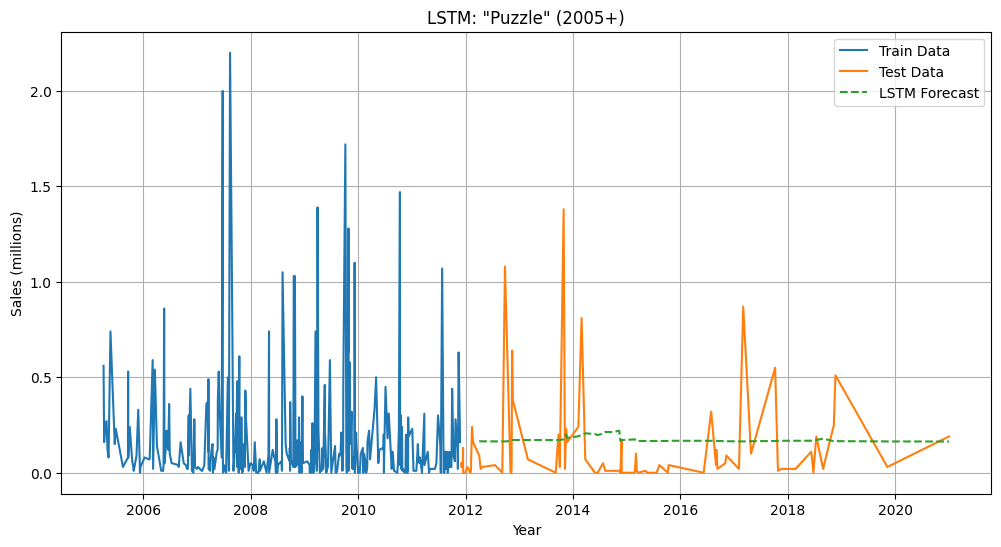

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


<ipython-input-69-56ecbd4689b7>:66: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - lstm_forecast) / y_test)) * 100


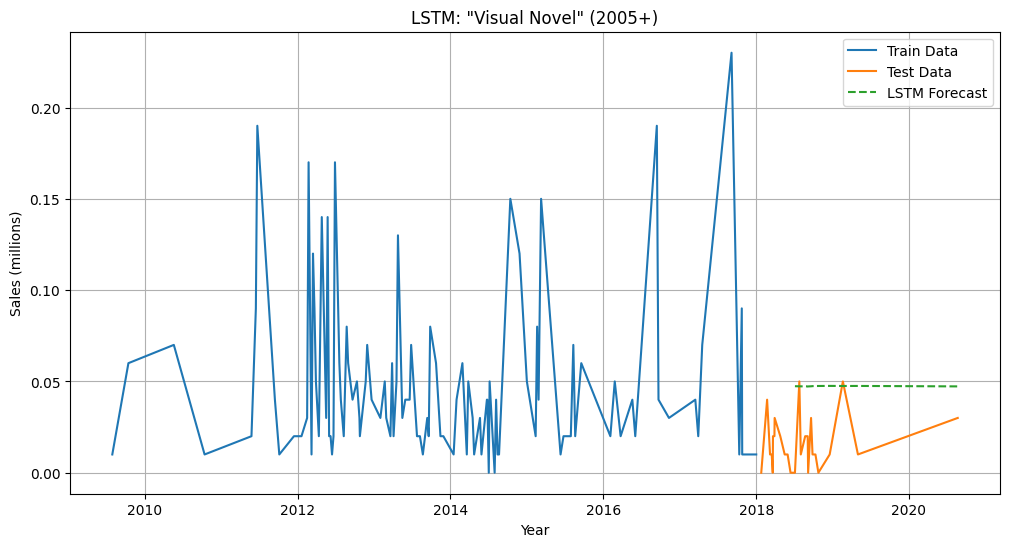

In [69]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


metrics_lstm = {}


genres = ['Action', 'Shooter', 'Action-Adventure', 'Sports', 'Role-Playing',
          'Simulation', 'Racing', 'Music', 'Misc', 'Fighting', 'Platform',
          'Adventure', 'Strategy', 'Puzzle', 'MMO', 'Sandbox', 'Party',
          'Education', 'Board Game', 'Visual Novel']


for genre in genres:
    genre_data = df[df['genre'] == genre].groupby('release_date')['total_sales'].sum().reset_index()
    genre_data.set_index('release_date', inplace=True)
    genre_data = genre_data.loc[genre_data.index >= '2005-01-01']


    if len(genre_data) < 24:
        continue


    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(genre_data)


    train_size = int(len(scaled_data) * 0.8)
    train, test = scaled_data[:train_size], scaled_data[train_size:]


    def create_sequences(data, seq_length=12):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])
            y.append(data[i + seq_length])
        return np.array(X), np.array(y)

    seq_length = 12
    X_train, y_train = create_sequences(train, seq_length)
    X_test, y_test = create_sequences(test, seq_length)


    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
        tf.keras.layers.LSTM(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')


    model.fit(X_train, y_train, epochs=60, batch_size=16, verbose=0)


    lstm_forecast = model.predict(X_test)
    lstm_forecast = scaler.inverse_transform(lstm_forecast)
    y_test = scaler.inverse_transform(y_test)


    mse = mean_squared_error(y_test, lstm_forecast)
    mae = mean_absolute_error(y_test, lstm_forecast)
    mape = np.mean(np.abs((y_test - lstm_forecast) / y_test)) * 100


    metrics_lstm[genre] = {'MSE': mse, 'MAE': mae}


    plt.figure(figsize=(12, 6))
    plt.plot(genre_data.index[:len(train)], scaler.inverse_transform(train), label='Train Data')
    plt.plot(genre_data.index[len(train):len(train) + len(test)], scaler.inverse_transform(test), label='Test Data')
    plt.plot(genre_data.index[len(train) + seq_length:], lstm_forecast, label='LSTM Forecast', linestyle='--')
    plt.title(f'LSTM: "{genre}" (2005+)')
    plt.xlabel('Year')
    plt.ylabel('Sales (millions)')
    plt.legend()
    plt.grid(True)
    plt.show()


# metrics_lstm_df = pd.DataFrame(metrics_lstm).T
# print(metrics_lstm_df)


LSTM metrics

In [71]:
metrics_lstm_df = pd.DataFrame(metrics_lstm).T
print(metrics_lstm_df)

                        MSE       MAE
Action             1.294148  0.945154
Shooter           26.153158  2.944014
Action-Adventure  27.932154  2.367332
Sports            14.122188  1.851039
Role-Playing       0.712330  0.462419
Simulation         0.301513  0.363126
Racing             0.586918  0.669133
Music              1.326452  1.147415
Misc               0.955921  0.574079
Fighting           0.719205  0.553873
Platform           0.817977  0.631630
Adventure          0.096260  0.262538
Strategy           0.020601  0.122261
Puzzle             0.071666  0.185843
Visual Novel       0.001106  0.030068


# Prophet prediction model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/_b14vfh5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/ye2fqvia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21945', 'data', 'file=/tmp/tmpme0qo84q/_b14vfh5.json', 'init=/tmp/tmpme0qo84q/ye2fqvia.json', 'output', 'file=/tmp/tmpme0qo84q/prophet_model1ykq7fpb/prophet_model-20241229171919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-73-3a134456065b>:36: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for 

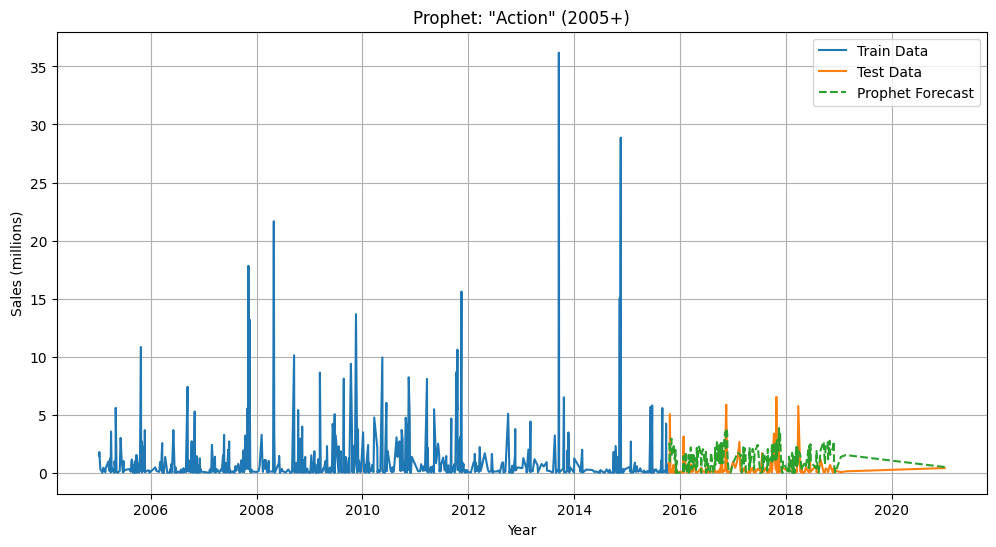

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/9a_mmky1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/lk7j_euu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36046', 'data', 'file=/tmp/tmpme0qo84q/9a_mmky1.json', 'init=/tmp/tmpme0qo84q/lk7j_euu.json', 'output', 'file=/tmp/tmpme0qo84q/prophet_modelad3tz_ez/prophet_model-20241229171920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-73-3a134456065b>:36: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for 

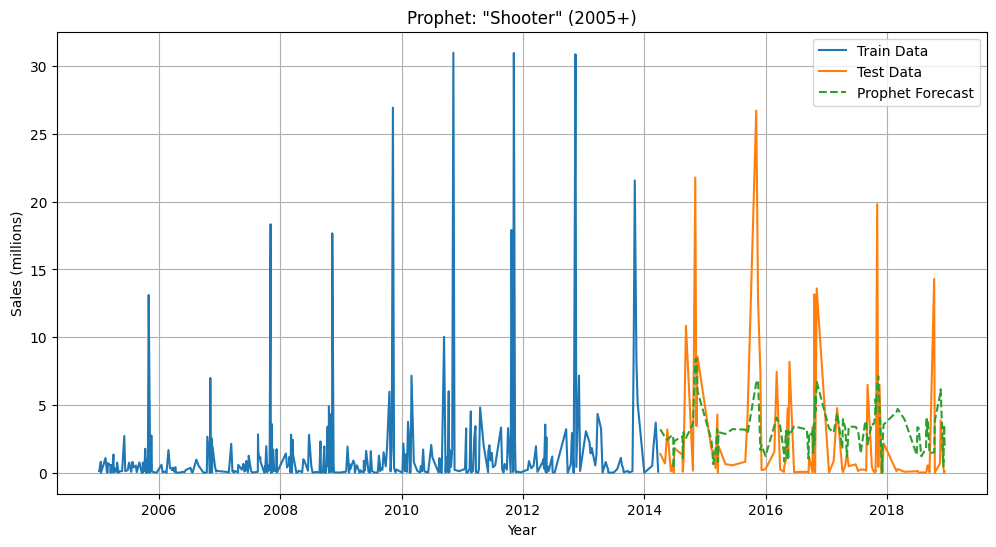

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/ti6rprzu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/_nmousvf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62874', 'data', 'file=/tmp/tmpme0qo84q/ti6rprzu.json', 'init=/tmp/tmpme0qo84q/_nmousvf.json', 'output', 'file=/tmp/tmpme0qo84q/prophet_modelfb7v09z4/prophet_model-20241229171920.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:19:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-73-3a134456065b>:36: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for

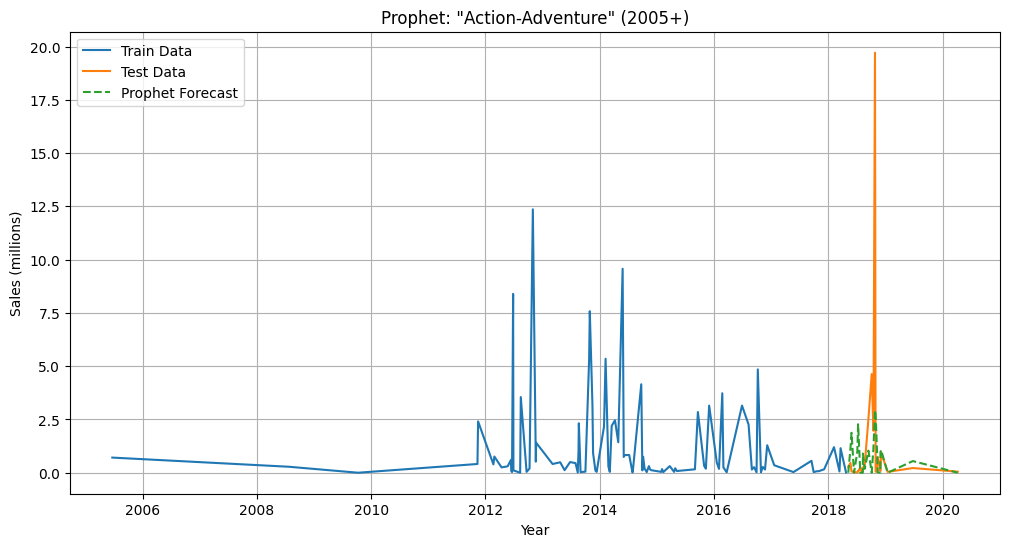

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/1jn5bhxg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/lbgyuvp_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30393', 'data', 'file=/tmp/tmpme0qo84q/1jn5bhxg.json', 'init=/tmp/tmpme0qo84q/lbgyuvp_.json', 'output', 'file=/tmp/tmpme0qo84q/prophet_model1ga1wzzg/prophet_model-20241229171921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-73-3a134456065b>:36: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for 

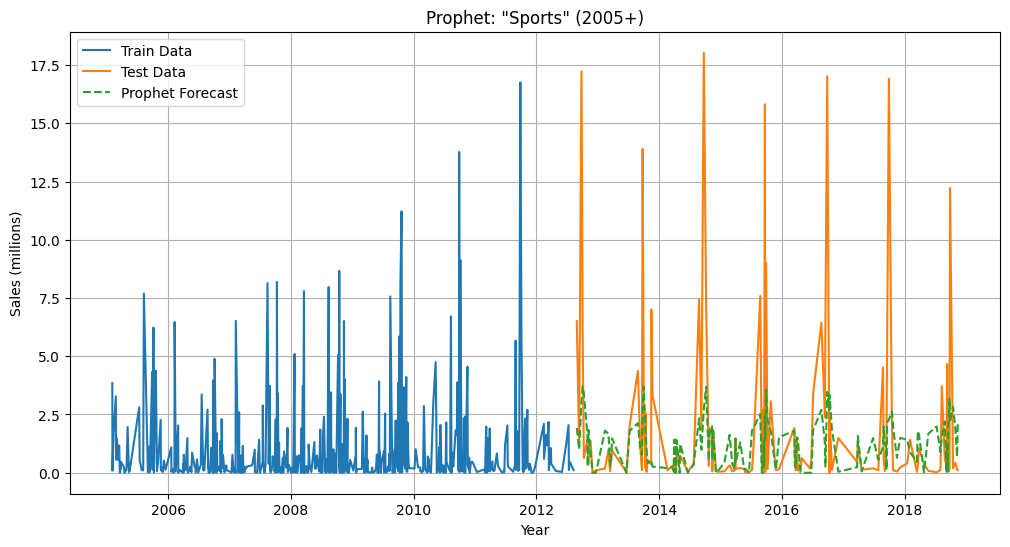

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/f02_bop8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/a1y4i6ao.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55408', 'data', 'file=/tmp/tmpme0qo84q/f02_bop8.json', 'init=/tmp/tmpme0qo84q/a1y4i6ao.json', 'output', 'file=/tmp/tmpme0qo84q/prophet_modelhi0fap6l/prophet_model-20241229171922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-73-3a134456065b>:36: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for 

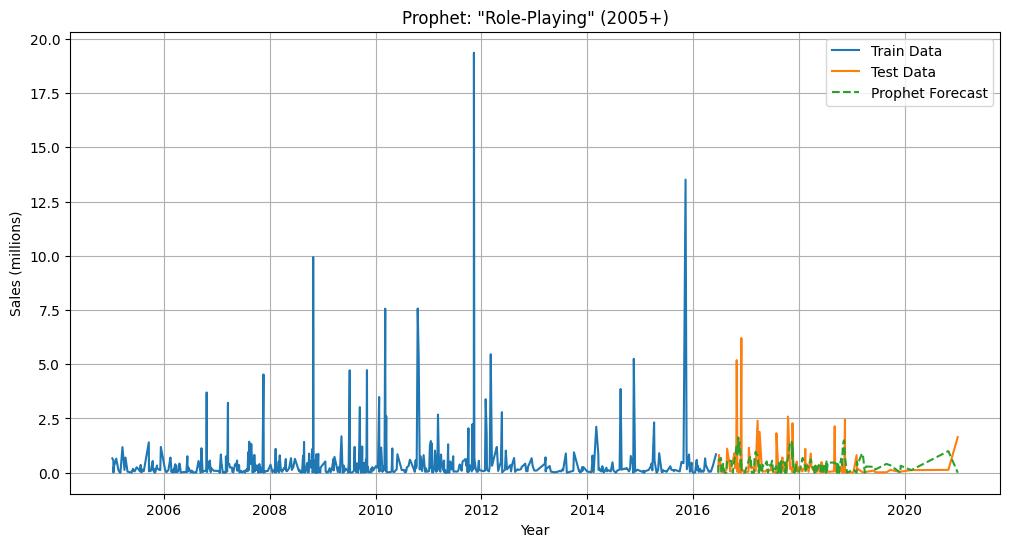

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/nl4524y9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/3d93i6eh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26192', 'data', 'file=/tmp/tmpme0qo84q/nl4524y9.json', 'init=/tmp/tmpme0qo84q/3d93i6eh.json', 'output', 'file=/tmp/tmpme0qo84q/prophet_modelp20c58ll/prophet_model-20241229171923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-73-3a134456065b>:36: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for 

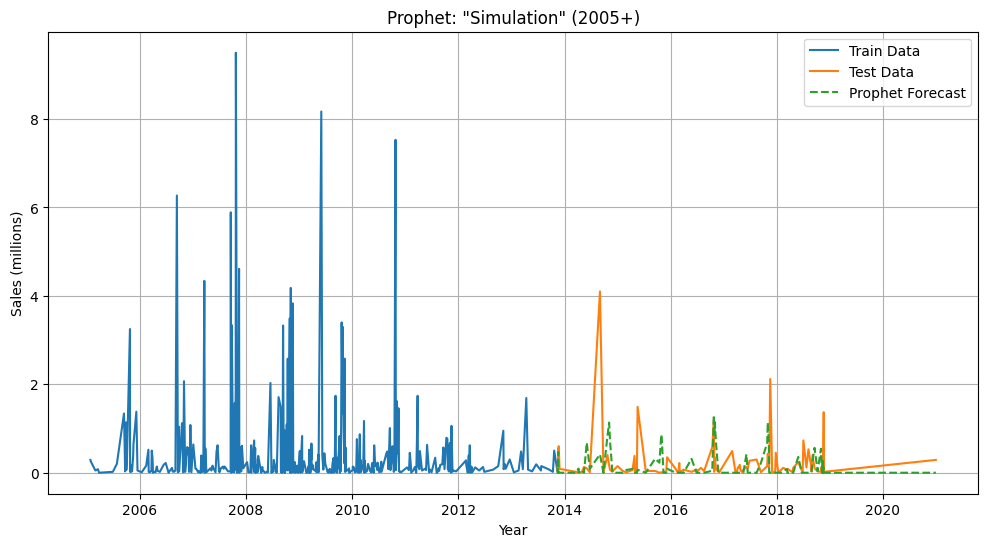

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/7kdd0393.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/niwn6bd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41191', 'data', 'file=/tmp/tmpme0qo84q/7kdd0393.json', 'init=/tmp/tmpme0qo84q/niwn6bd8.json', 'output', 'file=/tmp/tmpme0qo84q/prophet_modelqxcrsjxa/prophet_model-20241229171924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-73-3a134456065b>:36: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for 

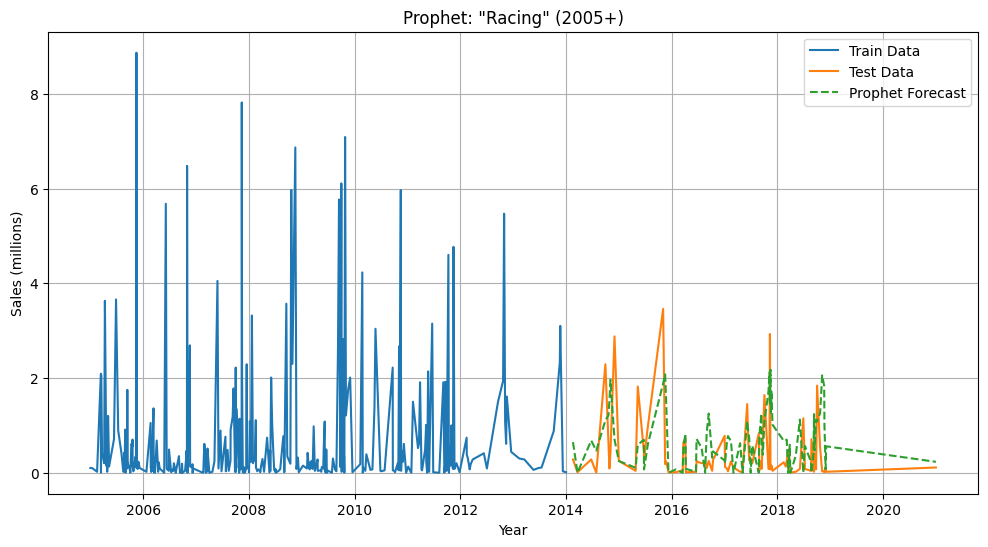

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/5u8mcl66.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/3dj0l7hh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75742', 'data', 'file=/tmp/tmpme0qo84q/5u8mcl66.json', 'init=/tmp/tmpme0qo84q/3dj0l7hh.json', 'output', 'file=/tmp/tmpme0qo84q/prophet_modela4clkzov/prophet_model-20241229171925.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:19:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-73-3a134456065b>:36: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for

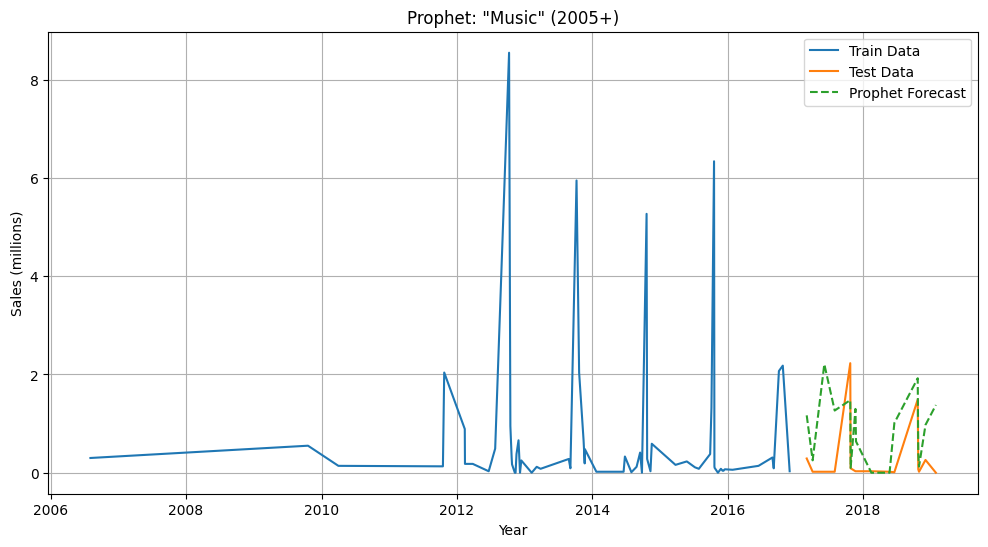

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/n01phkhl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/07b37vpf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57101', 'data', 'file=/tmp/tmpme0qo84q/n01phkhl.json', 'init=/tmp/tmpme0qo84q/07b37vpf.json', 'output', 'file=/tmp/tmpme0qo84q/prophet_model15e0lsc4/prophet_model-20241229171926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-73-3a134456065b>:36: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for 

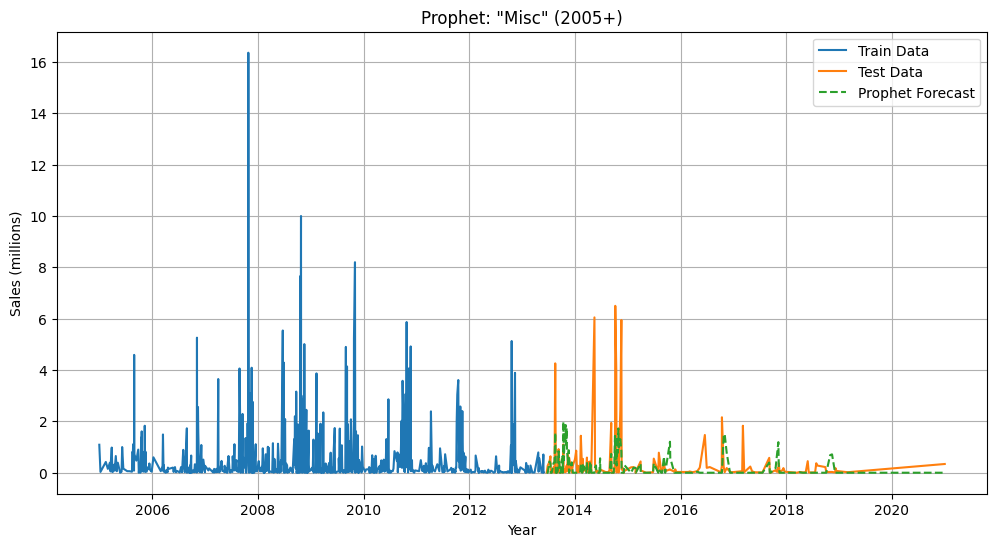

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/xkb9a62g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/lryp1na1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65808', 'data', 'file=/tmp/tmpme0qo84q/xkb9a62g.json', 'init=/tmp/tmpme0qo84q/lryp1na1.json', 'output', 'file=/tmp/tmpme0qo84q/prophet_model222gqgrz/prophet_model-20241229171927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-73-3a134456065b>:36: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for 

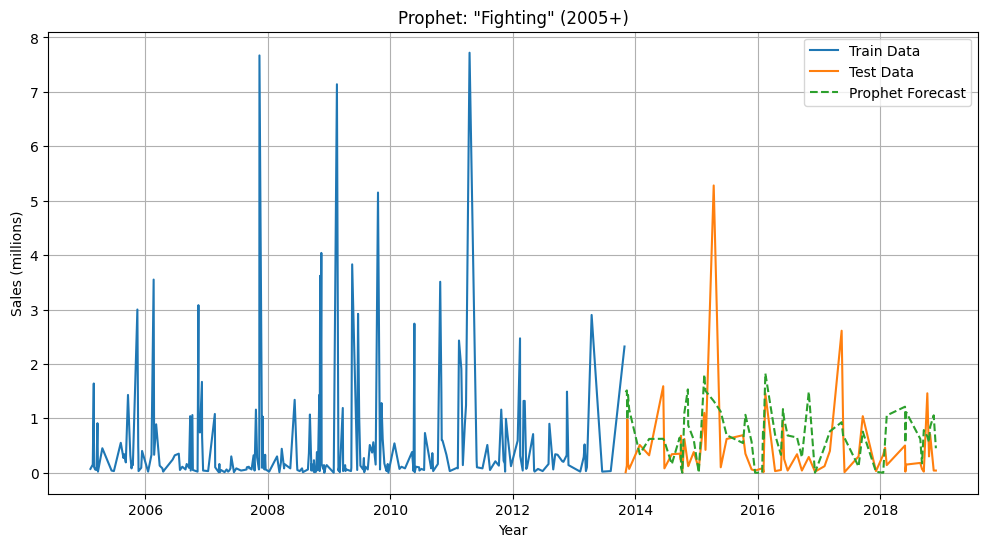

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/u2mjwep4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/gm5qu5ig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44472', 'data', 'file=/tmp/tmpme0qo84q/u2mjwep4.json', 'init=/tmp/tmpme0qo84q/gm5qu5ig.json', 'output', 'file=/tmp/tmpme0qo84q/prophet_modeld0jfj2t7/prophet_model-20241229171927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-73-3a134456065b>:36: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for 

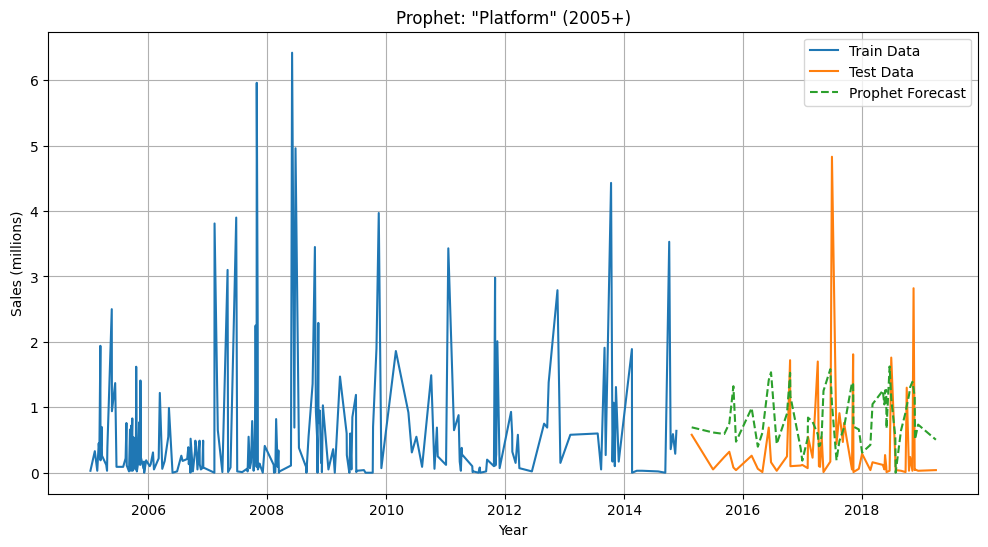

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/ye_cnxo_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/a1uto2u3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5959', 'data', 'file=/tmp/tmpme0qo84q/ye_cnxo_.json', 'init=/tmp/tmpme0qo84q/a1uto2u3.json', 'output', 'file=/tmp/tmpme0qo84q/prophet_modelhcfy7rh3/prophet_model-20241229171928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-73-3a134456065b>:36: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for i

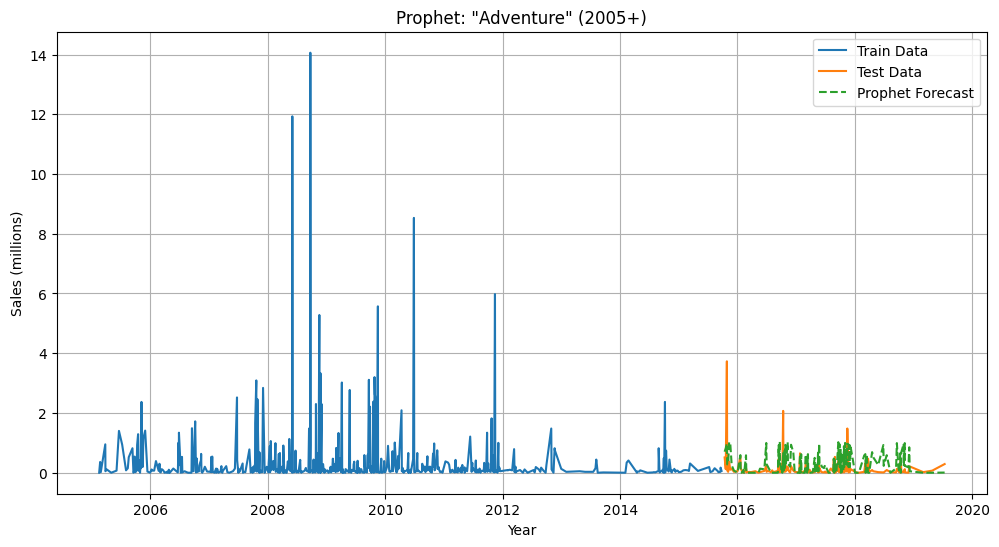

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/tu8s9qif.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/ksj8w7hn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89942', 'data', 'file=/tmp/tmpme0qo84q/tu8s9qif.json', 'init=/tmp/tmpme0qo84q/ksj8w7hn.json', 'output', 'file=/tmp/tmpme0qo84q/prophet_modelxwf1_p7r/prophet_model-20241229171939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-73-3a134456065b>:36: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for 

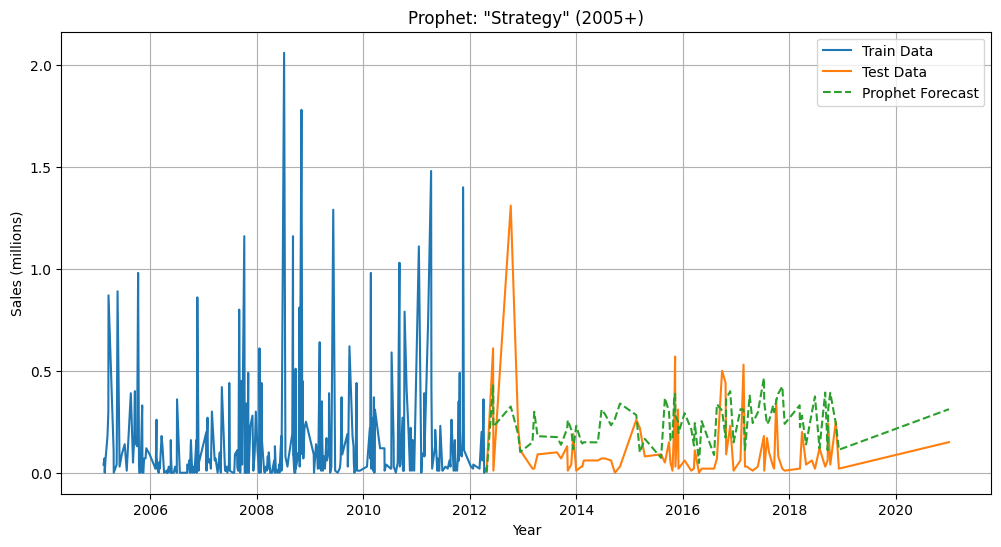

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/b7ms3fdr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/7z1ozsr3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45957', 'data', 'file=/tmp/tmpme0qo84q/b7ms3fdr.json', 'init=/tmp/tmpme0qo84q/7z1ozsr3.json', 'output', 'file=/tmp/tmpme0qo84q/prophet_modelw0qds98l/prophet_model-20241229171940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-73-3a134456065b>:36: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for 

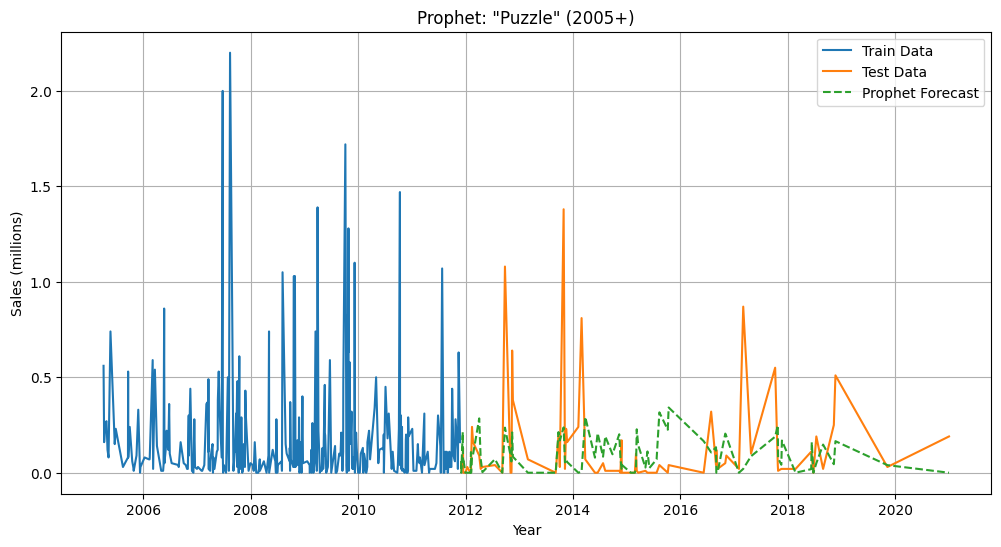

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/um54y6ww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme0qo84q/egli2vei.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49569', 'data', 'file=/tmp/tmpme0qo84q/um54y6ww.json', 'init=/tmp/tmpme0qo84q/egli2vei.json', 'output', 'file=/tmp/tmpme0qo84q/prophet_modelnzv_8o99/prophet_model-20241229171941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-73-3a134456065b>:36: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for 

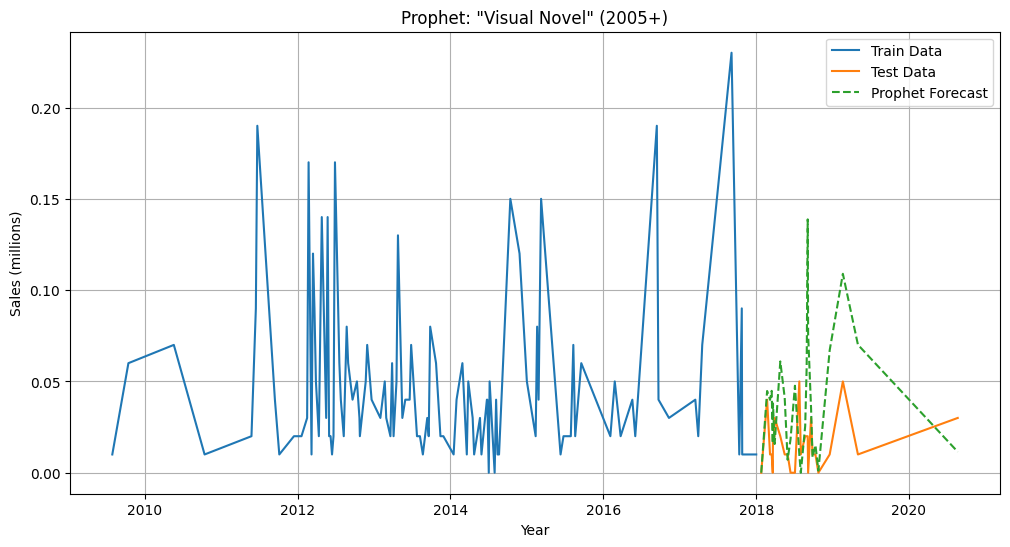

In [73]:
# Prophet
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

metrics = {}

for genre in genres:
    genre_data = df[df['genre'] == genre].groupby('release_date')['total_sales'].sum().reset_index()
    genre_data.set_index('release_date', inplace=True)
    genre_data = genre_data.loc[genre_data.index >= '2005-01-01']

    if len(genre_data) < 24:
        continue

    train_size = int(len(genre_data) * 0.8)
    train = genre_data.iloc[:train_size]
    test = genre_data.iloc[train_size:]

    prophet_train = train.reset_index().rename(columns={'release_date': 'ds', 'total_sales': 'y'})

    try:
        # Добавляем параметр floor для ограничения
        prophet_train['floor'] = 0

        prophet_model = Prophet()
        prophet_model.fit(prophet_train)

        future = test.reset_index()[['release_date']].rename(columns={'release_date': 'ds'})
        future['floor'] = 0  # Указываем нижнюю границу для прогноза
        prophet_forecast = prophet_model.predict(future)['yhat'].clip(lower=0)  # Применяем clip, чтобы убрать отрицательные значения

        mse = mean_squared_error(test['total_sales'], prophet_forecast)
        mae = mean_absolute_error(test['total_sales'], prophet_forecast)
        mape = np.mean(np.abs((test['total_sales'] - prophet_forecast) / test['total_sales'])) * 100

        metrics[genre] = {'MSE': mse, 'MAE': mae}

        plt.figure(figsize=(12, 6))
        plt.plot(train.index, train['total_sales'], label='Train Data')
        plt.plot(test.index, test['total_sales'], label='Test Data')
        plt.plot(test.index, prophet_forecast, label='Prophet Forecast', linestyle='--')
        plt.title(f'Prophet: "{genre}" (2005+)')
        plt.xlabel('Year')
        plt.ylabel('Sales (millions)')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f'Error for {genre}: {e}')

# metrics_df = pd.DataFrame(metrics).T
# print(metrics_df)


Prophet model evaluation metrics:

In [74]:
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

                        MSE       MAE
Action             2.039668  1.077569
Shooter           19.729948  3.179852
Action-Adventure  13.170426  1.552974
Sports            12.098361  1.760546
Role-Playing       0.675062  0.466551
Simulation         0.288171  0.266375
Racing             0.760920  0.652422
Music              0.839050  0.698742
Misc               0.963613  0.426577
Fighting           0.694707  0.583917
Platform           0.857752  0.716844
Adventure          0.194706  0.275279
Strategy           0.051390  0.182301
Puzzle             0.062746  0.150774
Visual Novel       0.001553  0.028011


# SARIMA VS LSTM VS PROPHET

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
I

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


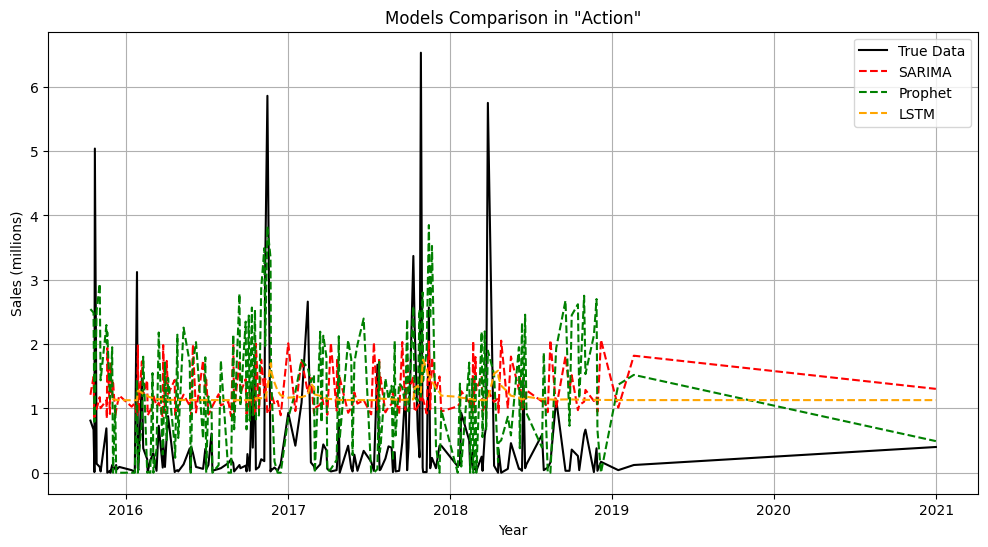

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
I

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


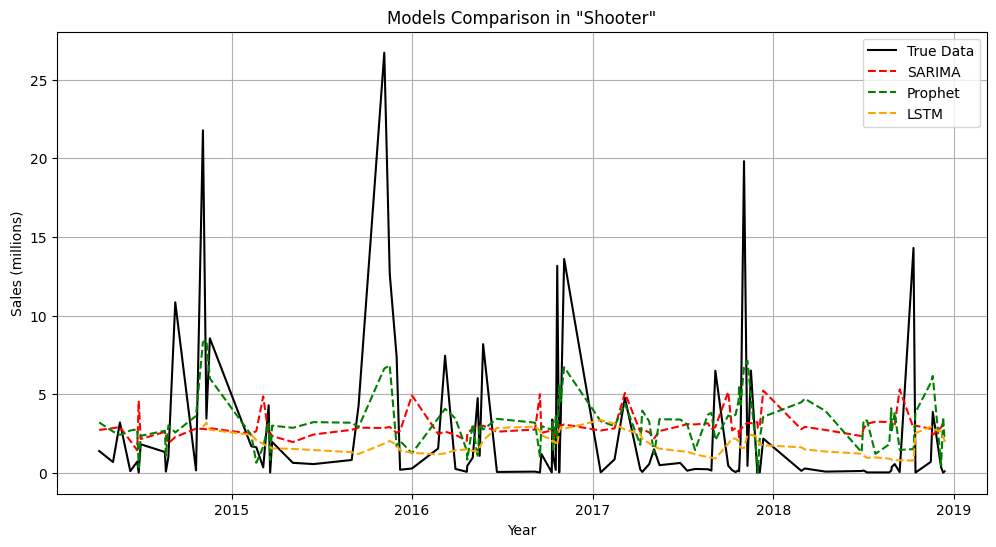

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
I

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


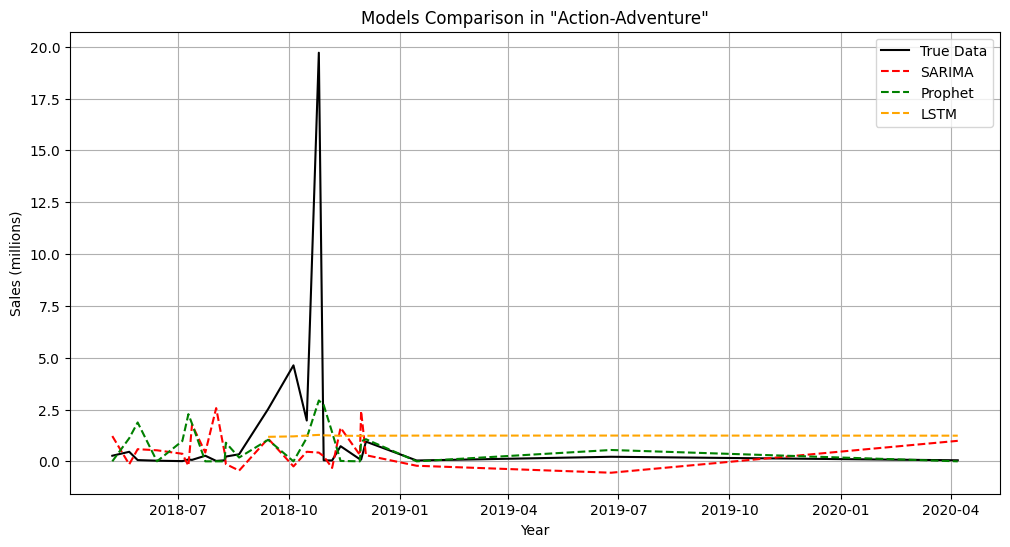

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
I

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


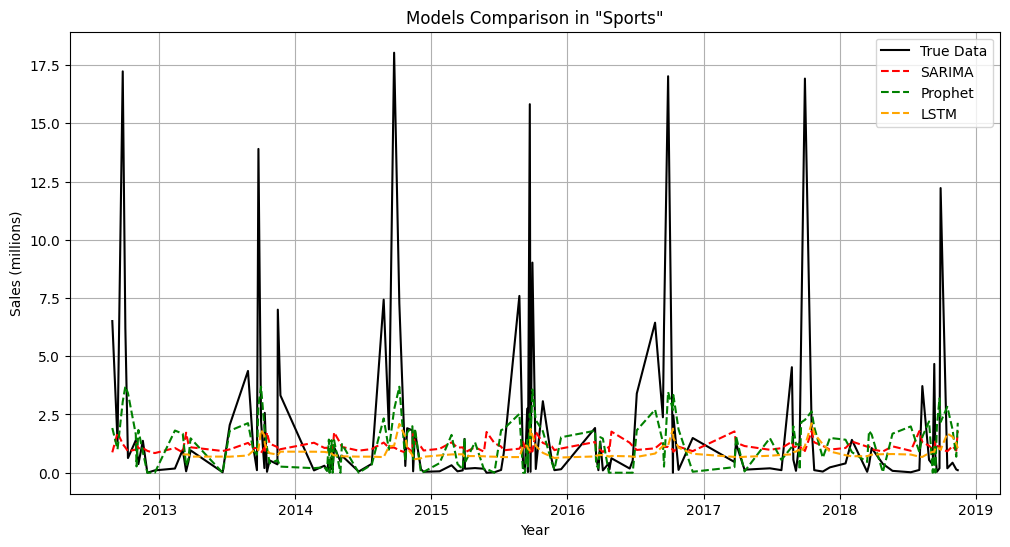

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
I

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


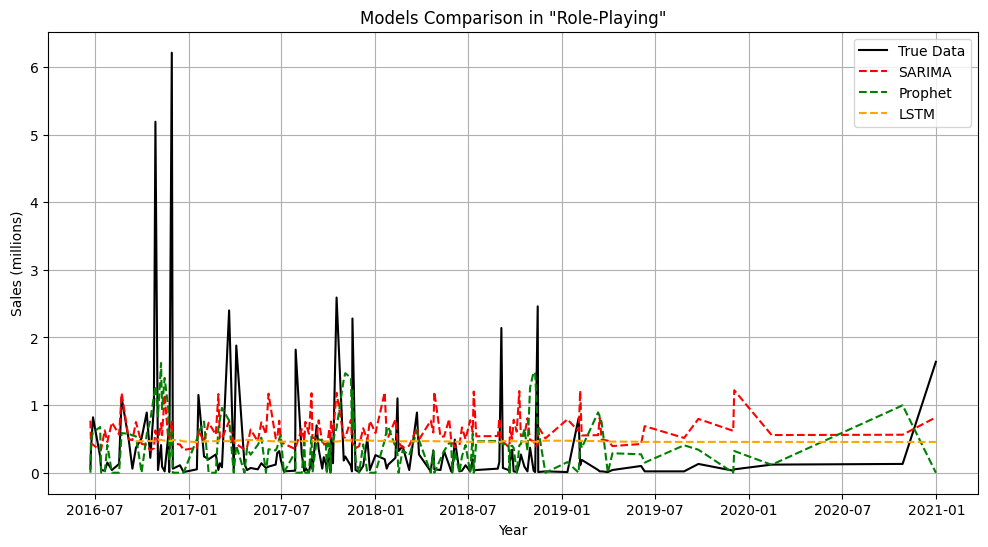

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
I

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


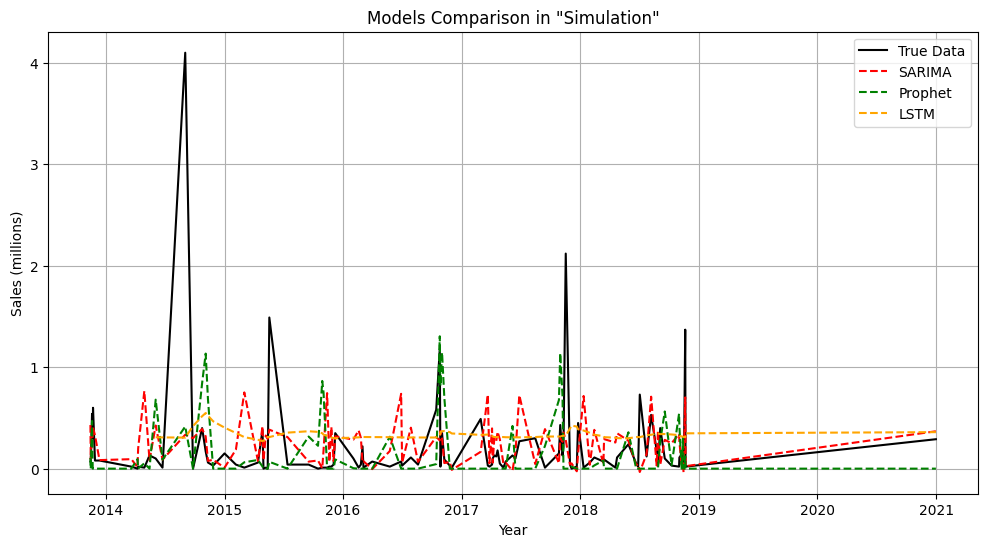

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
I

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


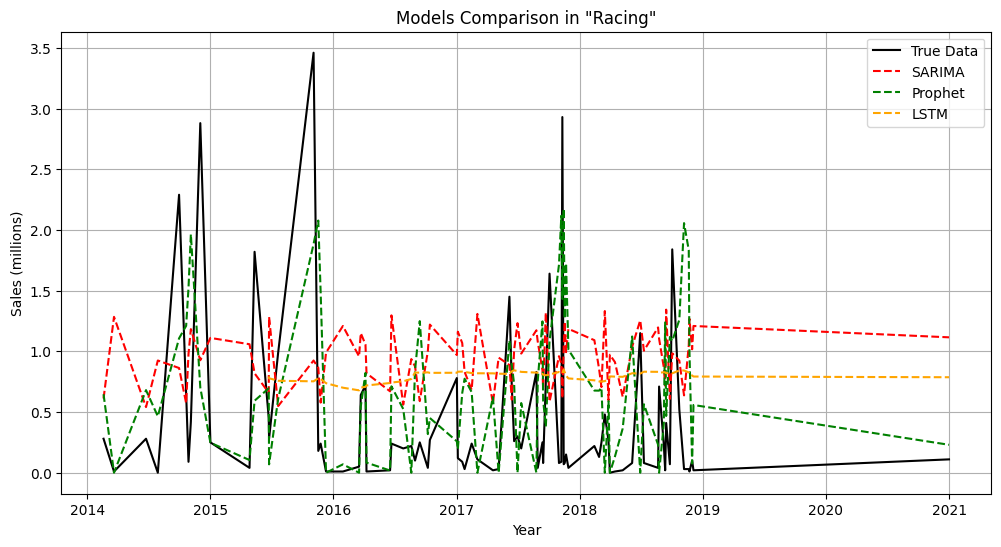

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-pack

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


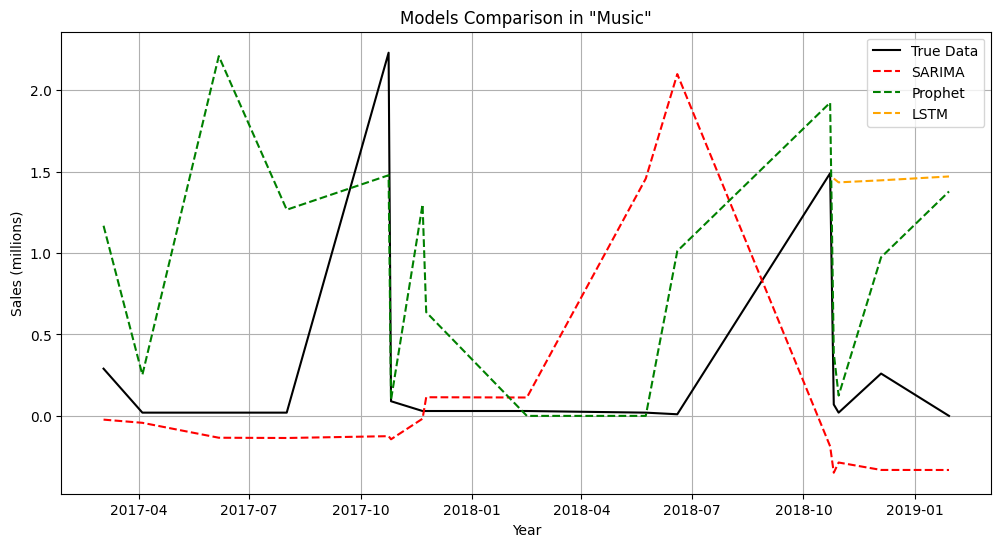

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
I

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


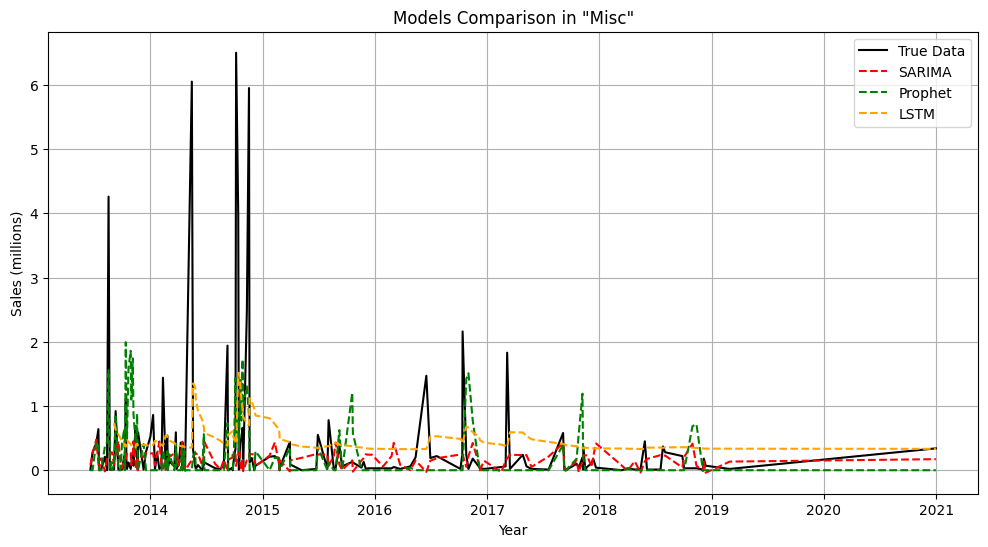

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
I

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


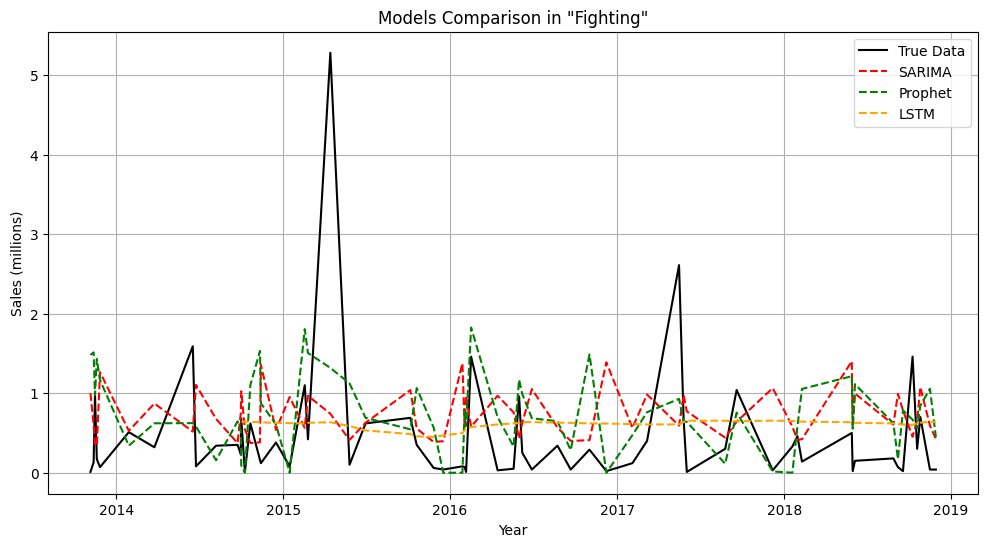

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
I

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step


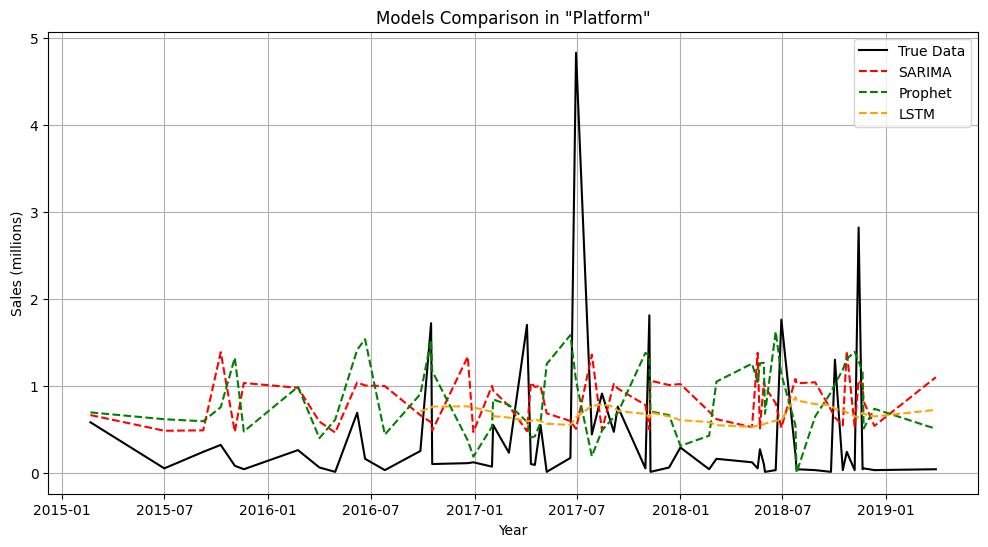

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
I

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


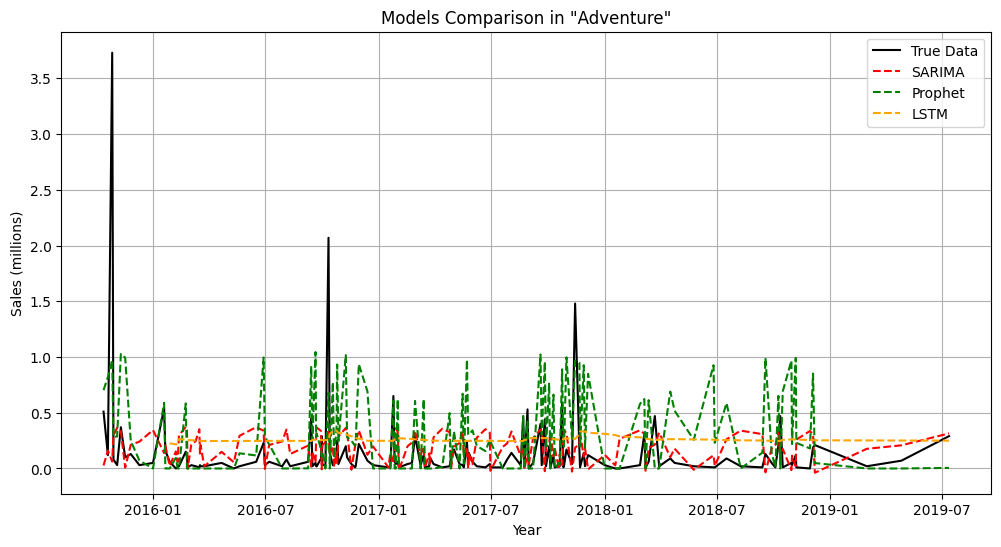

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/stat

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


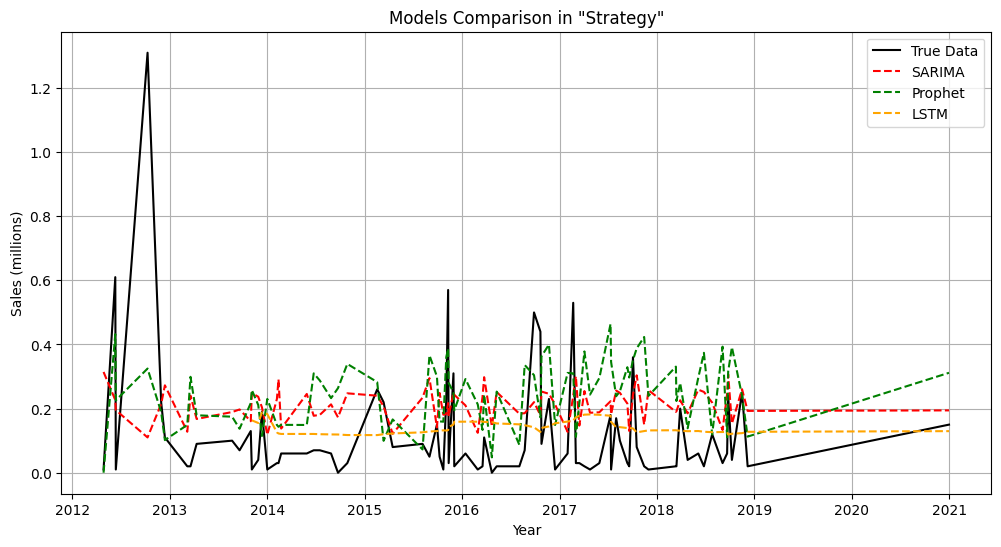

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
I

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


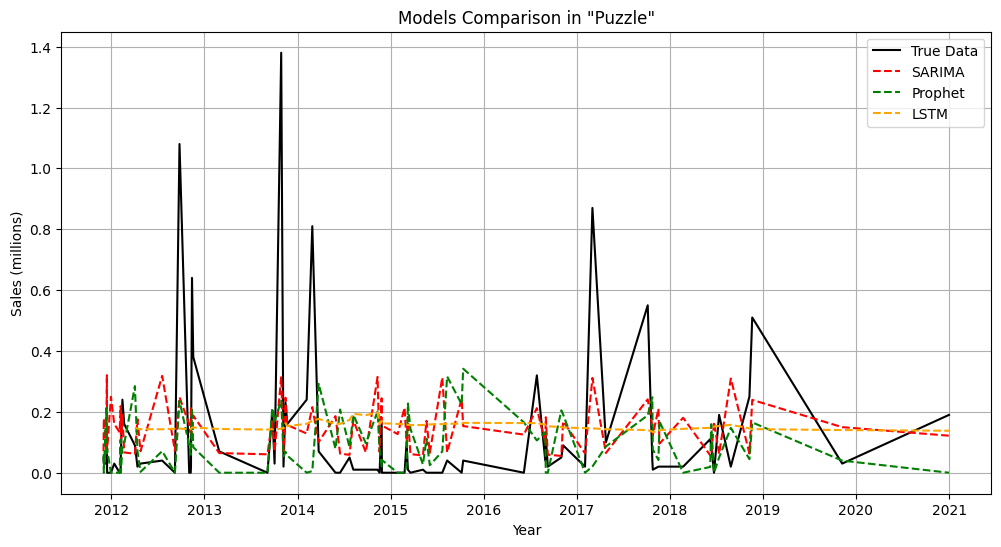

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
I

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


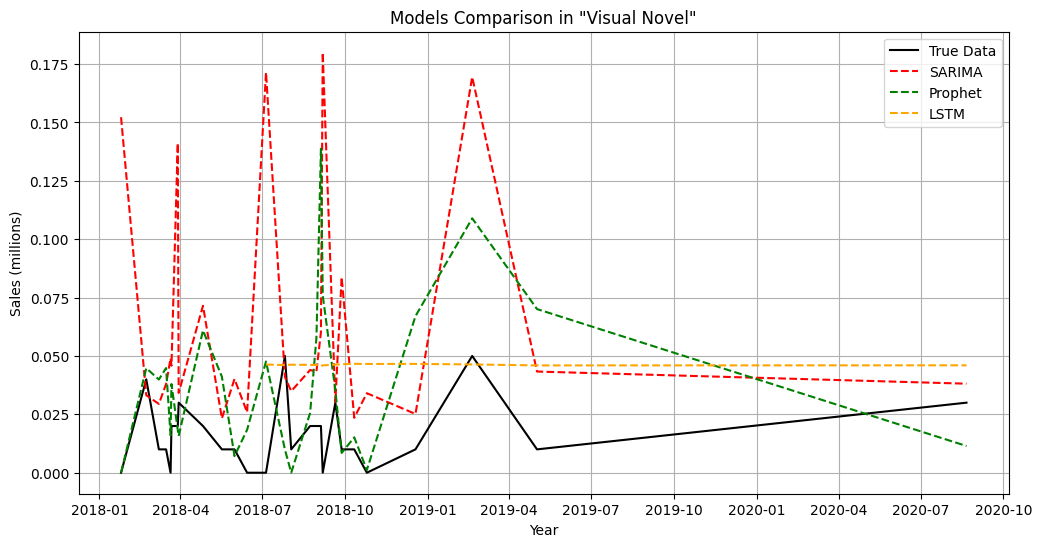

In [75]:
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

for genre in genres:
    try:

        genre_data = df[df['genre'] == genre].groupby('release_date')['total_sales'].sum().reset_index()
        genre_data.set_index('release_date', inplace=True)
        genre_data = genre_data.loc[genre_data.index >= '2005-01-01']

        if len(genre_data) < 24:
            continue


        train_size = int(len(genre_data) * 0.8)
        train = genre_data.iloc[:train_size]
        test = genre_data.iloc[train_size:]

        # --- SARIMA ---
        sarima_model = SARIMAX(train['total_sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_results = sarima_model.fit(disp=False)
        sarima_forecast = sarima_results.forecast(steps=len(test))

        # --- Prophet ---
        prophet_train = train.reset_index().rename(columns={'release_date': 'ds', 'total_sales': 'y'})
        prophet_train['floor'] = 0  # Ограничиваем прогнозы Prophet ниже 0

        prophet_model = Prophet()
        prophet_model.fit(prophet_train)

        future = test.reset_index()[['release_date']].rename(columns={'release_date': 'ds'})
        future['floor'] = 0
        prophet_forecast = prophet_model.predict(future)['yhat'].clip(lower=0)  # Исключаем отрицательные значения

        # --- LSTM ---
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(genre_data)

        train_scaled = scaled_data[:train_size]
        test_scaled = scaled_data[train_size:]

        def create_sequences(data, seq_length=12):
            X, y = [], []
            for i in range(len(data) - seq_length):
                X.append(data[i:i + seq_length])
                y.append(data[i + seq_length])
            return np.array(X), np.array(y)

        seq_length = 12
        X_train, y_train = create_sequences(train_scaled, seq_length)
        X_test, y_test = create_sequences(test_scaled, seq_length)

        lstm_model = tf.keras.Sequential([
            tf.keras.layers.LSTM(64, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
            tf.keras.layers.LSTM(32, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        lstm_model.compile(optimizer='adam', loss='mse')
        lstm_model.fit(X_train, y_train, epochs=60, batch_size=16, verbose=0)

        lstm_forecast = lstm_model.predict(X_test)
        lstm_forecast = scaler.inverse_transform(lstm_forecast)

        # Visualization
        plt.figure(figsize=(12, 6))
        plt.plot(test.index, test['total_sales'], label='True Data', color='black')
        plt.plot(test.index, sarima_forecast, label='SARIMA', linestyle='--', color='red')
        plt.plot(test.index, prophet_forecast, label='Prophet', linestyle='--', color='green')
        plt.plot(test.index[seq_length:], lstm_forecast.flatten(), label='LSTM', linestyle='--', color='orange')
        plt.title(f'Models Comparison in "{genre}"')
        plt.xlabel('Year')
        plt.ylabel('Sales (millions)')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f'Error for {genre}: {e}')


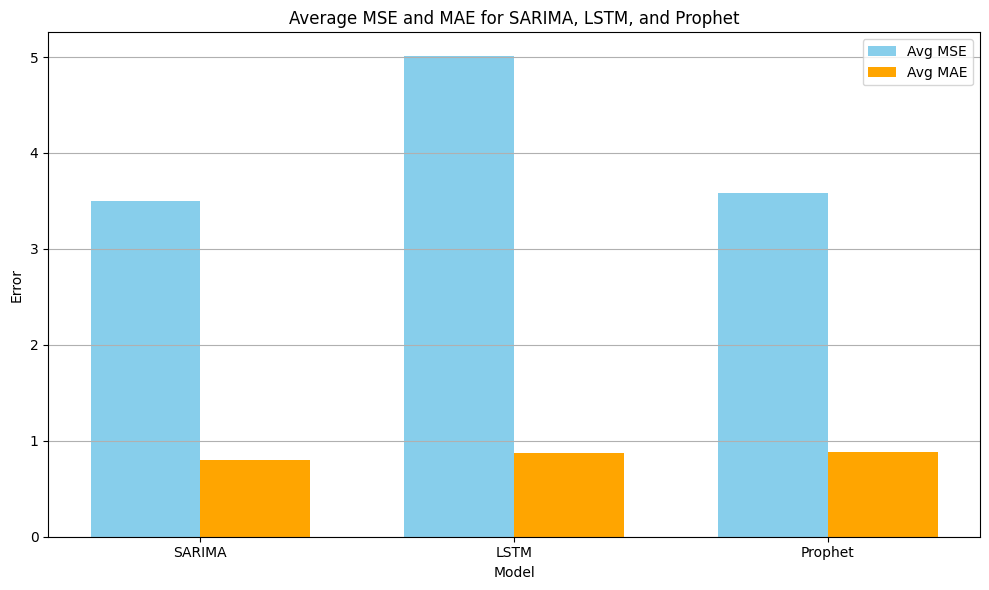

In [76]:
import pandas as pd
import matplotlib.pyplot as plt


metrics_summary = {
    'Model': ['SARIMA', 'LSTM', 'Prophet'],
    'Avg_MSE': [
        metrics_df['MSE'].mean(),        # SARIMA MSE
        metrics_lstm_df['MSE'].mean(),  # LSTM MSE
        metrics_prophet_df['MSE'].mean()  # Prophet MSE
    ],
    'Avg_MAE': [
        metrics_df['MAE'].mean(),        # SARIMA MAE
        metrics_lstm_df['MAE'].mean(),  # LSTM MAE
        metrics_prophet_df['MAE'].mean()  # Prophet MAE
    ]
}

metrics_comparison = pd.DataFrame(metrics_summary)


plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(metrics_comparison))

# MSE
plt.bar(index, metrics_comparison['Avg_MSE'], bar_width, label='Avg MSE', color='skyblue')

# MAE
plt.bar([i + bar_width for i in index], metrics_comparison['Avg_MAE'], bar_width, label='Avg MAE', color='orange')

plt.title('Average MSE and MAE for SARIMA, LSTM, and Prophet')
plt.xlabel('Model')
plt.ylabel('Error')
plt.xticks([i + bar_width / 2 for i in index], metrics_comparison['Model'])
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Conclusion

In this project, we tested three time series forecasting models: SARIMA, LSTM, and Prophet. We evaluated their performance using MSE and MAE metrics and visually compared their forecasts to real data.

***Key findings***:
SARIMA showed moderate performance, following seasonal trends but exhibiting bias and overestimation of peaks in the data.
Prophet produced smoother forecasts, allowing it to model the overall trend, but it struggles to handle sharp changes and sales peaks.
LSTM, despite low error rates in a number of categories, demonstrated "flat" forecasts, which may be due to limitations in the quality of the input data and the specificity of the model.

# Discussion

Despite the relatively low error rates, the forecast plots are far from ideal. All three models were somewhat limited in their ability to effectively model the time series of this dataset. The main reason for this may be the nature of the original dataset itself:

The data is aggregated by categories, rather than presented at high temporal granularity (e.g. daily or weekly), which makes it difficult to model trends and seasonality.
The lack of additional features (e.g. marketing events, seasonal effects) also negatively affected the forecasting results.
Unfortunately, there are no open-source datasets that would meet our goals, and the available paid datasets require significant financial investments.
